<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/presion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Process the uploaded CSV "/mnt/data/Pre.csv" as requested.
import pandas as pd
import re
from pathlib import Path
from datetime import timedelta
import numpy as np

inp_path = Path("/content/Pre.csv")
out_clean = Path("/content/Pre_clean.csv")
out_segments = Path("/content/Pre_segments.csv")

# 1) Load CSV (robust to comma/semicolon/tab)
try:
    df = pd.read_csv(inp_path, sep=None, engine="python")
except Exception as e:
    # fallback: try comma
    df = pd.read_csv(inp_path)

# 2) Detect columns
# Try a few variants for the cm column
cm_raw_col = None
for cand in ["cm H20", "cm H2O", "cmH2O", "cmH20", "cm", "cmH_20"]:
    if cand in df.columns:
        cm_raw_col = cand
        break
if cm_raw_col is None:
    raise ValueError(f"No encuentro la columna de cm en {list(df.columns)}")

# Lectura column
lec_col = None
for cand in ["Lectura esp32", "lectura esp32", "Lectura", "Raw", "Lectura_esp32"]:
    if cand in df.columns:
        lec_col = cand
        break
if lec_col is None:
    raise ValueError(f"No encuentro la columna 'Lectura esp32' en {list(df.columns)}")

# Preserve the raw cm column before forward-fill
df["cm_raw"] = df[cm_raw_col]

# 3) Forward-fill cm values
df["cm"] = df["cm_raw"].ffill()

# Coerce cm to numeric if possible
df["cm"] = pd.to_numeric(df["cm"], errors="coerce")

# 4) Parse "Lectura esp32" with regex
PAT = re.compile(
    r"""^\s*
        (?P<hora>\d{2}:\d{2}:\d{2}\.\d{3})      # 19:09:46.754
        \s*->\s*RAW\s+signed:\s*(?P<signed>-?\d+)
        \s*\|\s*RAW\s+unsigned:\s*(?P<unsigned>\d+)
        \s*\(bin\s*(?P<bin>[01\s]+)\)
        """, re.X
)

def parse_row(text):
    if pd.isna(text):
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA],
                         index=["hora","RAW_signed","RAW_unsigned","bin"])
    m = PAT.search(str(text))
    if not m:
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA],
                         index=["hora","RAW_signed","RAW_unsigned","bin"])
    return pd.Series([
        m.group("hora"),
        int(m.group("signed")),
        int(m.group("unsigned")),
        m.group("bin").replace(" ", "")
    ], index=["hora","RAW_signed","RAW_unsigned","bin"])

parsed = df[lec_col].apply(parse_row)
df = pd.concat([df, parsed], axis=1)

# Drop rows that didn't parse
df = df.dropna(subset=["RAW_signed","RAW_unsigned"]).copy()

# 5) Convert hour to datetime (no date)
df["hora_dt"] = pd.to_datetime(df["hora"], format="%H:%M:%S.%f", errors="coerce")

# 6) Build segments: a new segment starts each time the original cm_raw cell is non-null
is_new_block = df["cm_raw"].notna()
df["segment_id"] = is_new_block.cumsum()

# Also create a per-cm running index (e.g., 3.4#1, 3.4#2, ...)
df["cm_run"] = np.where(is_new_block, 1, 0)
df["cm_run"] = df.groupby("cm")["cm_run"].cumsum()

# 7) Compute per-segment stats including standard deviation
g = df.groupby("segment_id", dropna=False)
seg_stats = g.agg(
    cm=("cm","first"),
    cm_run=("cm_run","first"),
    n=("segment_id","size"),
    mean_signed=("RAW_signed","mean"),
    std_signed=("RAW_signed", lambda s: float(np.std(s, ddof=1)) if len(s)>1 else float("nan")), # Calculate std dev
    mean_unsigned=("RAW_unsigned","mean"),
    std_unsigned=("RAW_unsigned", lambda s: float(np.std(s, ddof=1)) if len(s)>1 else float("nan")), # Calculate std dev
    start_time=("hora_dt","min"),
    end_time=("hora_dt","max")
).reset_index()
seg_stats["duration_s"] = (seg_stats["end_time"] - seg_stats["start_time"]).dt.total_seconds()

# Add pressure conversions
CMH2O_TO_MMHG = 0.735559240
seg_stats["cmHg"] = seg_stats["cm"] / 13.5951
seg_stats["mmHg"] = seg_stats["cm"] * CMH2O_TO_MMHG
seg_stats["dP_mmHg"] = 0.05 * CMH2O_TO_MMHG # Assuming 0.05 cm uncertainty


# 8) Attach means to each row
df = df.merge(seg_stats[["segment_id","mean_signed","mean_unsigned","n"]], on="segment_id", how="left")
df.rename(columns={
    "mean_signed":"seg_mean_signed",
    "mean_unsigned":"seg_mean_unsigned",
    "n":"seg_n"
}, inplace=True)

# 9) Select and order output columns
cols_out = [
    "cm","cm_run","segment_id","seg_n",
    "hora","RAW_signed","RAW_unsigned","bin",
    "seg_mean_signed","seg_mean_unsigned"
]
# keep originals for convenience at the end
others = [c for c in df.columns if c not in cols_out]
df_out = df[cols_out + others]

# 10) Save outputs - Save seg_stats with new columns
df_out.to_csv(out_clean, index=False)
seg_stats.to_csv(out_segments, index=False)

# Preview to user
# from caas_jupyter_tools import display_dataframe_to_user
# display_dataframe_to_user("Vista previa - Datos limpios (primeras 200 filas)", df_out.head(200))
# display_dataframe_to_user("Resumen por segmentos", seg_stats)

out_clean, out_segments, df_out.shape, seg_stats.shape

(PosixPath('/content/Pre_clean.csv'),
 PosixPath('/content/Pre_segments.csv'),
 (1602, 14),
 (162, 14))

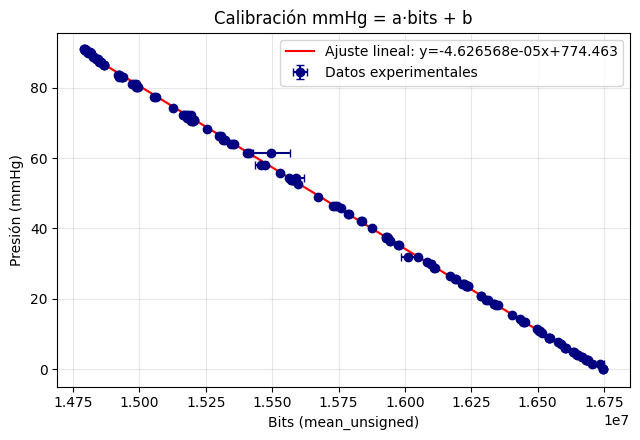

,Parámetro,Valor
0,Pendiente a,-4.626568e-05
1,Intercepto b,7.744630e+02
2,σ(a),6.465164e-08
3,σ(b),1.015831e+00
4,R²,9.996935e-01
5,N,1.590000e+02



Ecuación del ajuste:
mmHg = (-4.626568e-05 ± 6.465164e-08)·bits + (774.463 ± 1.016)
R² = 0.999694


In [1]:
# ===== Calibración mmHg vs mean_unsigned (con incertidumbre 95%) =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# === 1. Cargar datos ===
# Debe contener columnas: mean_unsigned, std_unsigned, mmHg, dP_mmHg
fname = "Pre_segments_stats.csv"   # o el que tengas
df = pd.read_csv(fname)

# Coerce numéricos
cols = ["mean_unsigned","std_unsigned","mmHg"]
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# === 2. Definir variables ===
x = df["mean_unsigned"].values
y = df["mmHg"].values
xerr = df["std_unsigned"].values if "std_unsigned" in df else None
yerr = np.full_like(y, 0.05*0.7356) if "dP_mmHg" not in df else df["dP_mmHg"].values

# === 3. Ajuste lineal con incertidumbre ===
coef, cov = np.polyfit(x, y, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))

# Predicciones
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 300)
y_fit = a*x_line + b

# Intervalo de confianza 95%
n = len(x)
alpha = 0.05
t_val = stats.t.ppf(1 - alpha/2, n-2)
s_yx = np.sqrt(np.sum((y - (a*x + b))**2) / (n-2))
x_mean = np.mean(x)
conf = t_val * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
y_upper = y_fit + conf
y_lower = y_fit - conf

# === 4. Gráfico ===
plt.figure(figsize=(6.5,4.5))
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, color='navy', label="Datos experimentales")
plt.plot(x_line, y_fit, 'r-', label=f"Ajuste lineal: y={a:.6e}x+{b:.3f}")
plt.fill_between(x_line, y_lower, y_upper, color='red', alpha=0.2, label="")
plt.xlabel("Bits (mean_unsigned)")
plt.ylabel("Presión (mmHg)")
plt.title("Calibración mmHg = a·bits + b")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fit_mmHg_vs_mean_unsigned_95CI.png", dpi=300)
plt.show()

# === 5. Resumen analítico ===
r2 = 1 - ((y - (a*x+b))**2).sum()/((y - y.mean())**2).sum()
summary = pd.DataFrame({
    "Parámetro":["Pendiente a","Intercepto b","σ(a)","σ(b)","R²","N"],
    "Valor":[a,b,sa,sb,r2,len(x)]
})
display(summary)
print("\nEcuación del ajuste:")
print(f"mmHg = ({a:.6e} ± {sa:.6e})·bits + ({b:.3f} ± {sb:.3f})")
print(f"R² = {r2:.6f}")


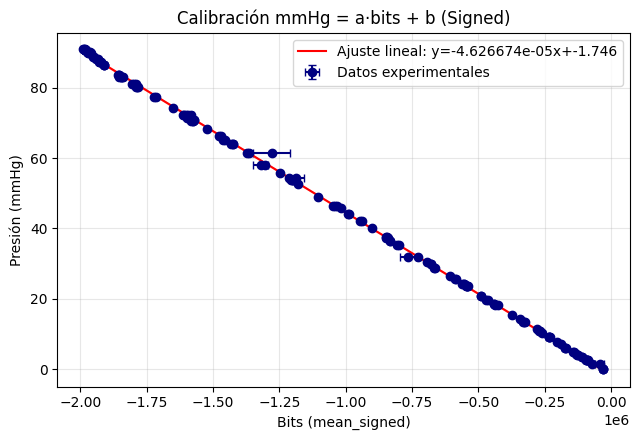

,Parámetro,Valor
0,Pendiente a,-4.626674e-05
1,Intercepto b,-1.746143e+00
2,σ(a),6.566635e-08
3,σ(b),8.367961e-02
4,R²,9.996838e-01
5,N,1.590000e+02



Ecuación del ajuste (Signed):
mmHg = (-4.626674e-05 ± 6.566635e-08)·bits + (-1.746 ± 0.084)
R² = 0.999684


In [ ]:
# ===== Calibración mmHg vs mean_signed (con incertidumbre 95%) =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# Assuming seg_stats DataFrame is available from previous cells
# If not, you might need to load it:
try:
    seg_stats = pd.read_csv("Pre_segments_stats.csv")
except FileNotFoundError:
     raise FileNotFoundError("Segment statistics file not found at /content/Pre_segments.csv. Please run the previous cell to generate it.")


# Explicitly convert relevant columns to numeric after loading and then to float64
for col in ["mmHg", "mean_signed", "std_signed", "dP_mmHg"]:
    if col in seg_stats.columns:
        seg_stats[col] = pd.to_numeric(seg_stats[col], errors="coerce").astype(np.float64)


# Drop rows with NA in relevant columns before filtering
seg_stats_filtered_s = seg_stats.dropna(subset=["mmHg", "mean_signed", "std_signed", "dP_mmHg"]).copy()


# Use only segments with finite mmHg & mean_signed using pd.isna()
fit_df_s = seg_stats_filtered_s[~pd.isna(seg_stats_filtered_s["mmHg"]) & ~pd.isna(seg_stats_filtered_s["mean_signed"])].copy()

# Define variables for signed fit
x_s = fit_df_s["mean_signed"].values
y_s = fit_df_s["mmHg"].values
xerr_s = fit_df_s["std_signed"].values
yerr_s = fit_df_s["dP_mmHg"].values

# === 3. Ajuste lineal con incertidumbre ===
coef_s, cov_s = np.polyfit(x_s, y_s, 1, cov=True)
a_s, b_s = coef_s
sa_s, sb_s = np.sqrt(np.diag(cov_s))

# Predicciones
x_line_s = np.linspace(np.nanmin(x_s), np.nanmax(x_s), 300)
y_fit_s = a_s*x_line_s + b_s

# Intervalo de confianza 95%
n_s = len(x_s)
alpha = 0.05
t_val_s = stats.t.ppf(1 - alpha/2, n_s-2)
# Calculate s_yx for the signed fit
s_yx_s = np.sqrt(np.sum((y_s - (a_s*x_s + b_s))**2) / (n_s-2))
x_mean_s = np.mean(x_s)
conf_s = t_val_s * s_yx_s * np.sqrt(1/n_s + (x_line_s - x_mean_s)**2 / np.sum((x_s - x_mean_s)**2))
y_upper_s = y_fit_s + conf_s
y_lower_s = y_fit_s - conf_s


# === 4. Gráfico ===
plt.figure(figsize=(6.5,4.5))
plt.errorbar(x_s, y_s, xerr=xerr_s, yerr=yerr_s, fmt='o', capsize=3, color='navy', label="Datos experimentales")
plt.plot(x_line_s, y_fit_s, 'r-', label=f"Ajuste lineal: y={a_s:.6e}x+{b_s:.3f}")
plt.fill_between(x_line_s, y_lower_s, y_upper_s, color='red', alpha=0.2, label="")
plt.xlabel("Bits (mean_signed)")
plt.ylabel("Presión (mmHg)")
plt.title("Calibración mmHg = a·bits + b (Signed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fit_mmHg_vs_mean_signed_95CI.png", dpi=300)
plt.show()

# === 5. Resumen analítico ===
r2_s = 1 - ((y_s - (a_s*x_s+b_s))**2).sum()/((y_s - y_s.mean())**2).sum()
summary_s = pd.DataFrame({
    "Parámetro":["Pendiente a","Intercepto b","σ(a)","σ(b)","R²","N"],
    "Valor":[a_s,b_s,sa_s,sb_s,r2_s,len(x_s)]
})
display(summary_s)
print("\nEcuación del ajuste (Signed):")
print(f"mmHg = ({a_s:.6e} ± {sa_s:.6e})·bits + ({b_s:.3f} ± {sb_s:.3f})")
print(f"R² = {r2_s:.6f}")

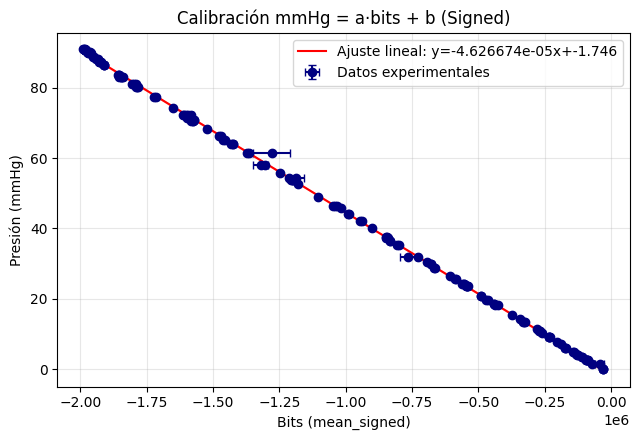

,Parámetro,Valor
0,Pendiente a,-4.626674e-05
1,Intercepto b,-1.746143e+00
2,σ(a),6.566635e-08
3,σ(b),8.367961e-02
4,R²,9.996838e-01
5,N,1.590000e+02



Ecuación del ajuste (Signed):
mmHg = (-4.626674e-05 ± 6.566635e-08)·bits + (-1.746 ± 0.084)
R² = 0.999684
Figura guardada en: fit_mmHg_vs_mean_signed_95CI.png


In [ ]:
# ===== Calibración mmHg vs mean_signed (con incertidumbre 95%) =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# === 1. Cargar datos ===
# Debe (idealmente) contener: mean_signed, std_signed, mmHg, dP_mmHg
fname = "Pre_segments_stats.csv"   # cambia si tu archivo tiene otro nombre
df = pd.read_csv(fname)

# Coerce numéricos (si alguna falta, no truena)
needed_cols = ["mean_signed", "std_signed", "mmHg", "dP_mmHg"]
for c in needed_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Filtrar filas válidas para el ajuste (requiere mmHg y mean_signed)
fit_df = df.dropna(subset=["mmHg", "mean_signed"]).copy()

if len(fit_df) < 3:
    raise ValueError(
        f"Se requieren ≥3 puntos para ajustar con IC. Solo hay {len(fit_df)} "
        "filas válidas con 'mmHg' y 'mean_signed'."
    )

# === 2. Definir variables ===
x = fit_df["mean_signed"].values.astype(float)
y = fit_df["mmHg"].values.astype(float)

# xerr opcional si existe std_signed (si no, None)
xerr = fit_df["std_signed"].values.astype(float) if "std_signed" in fit_df else None

# yerr: usa dP_mmHg si existe; si no, un valor por defecto (igual criterio que tu script unsigned)
# (0.05*0.7356 es el ejemplo de incertidumbre mínima usada en el otro script)
if "dP_mmHg" in fit_df:
    yerr = fit_df["dP_mmHg"].values.astype(float)
else:
    yerr = np.full_like(y, 0.05*0.7356, dtype=float)

# === 3. Ajuste lineal con incertidumbre (polyfit + covarianza) ===
coef, cov = np.polyfit(x, y, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))

# Predicciones para la recta
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 300)
y_fit = a*x_line + b

# Intervalo de confianza del ajuste (95%) para la media de la predicción
n = len(x)
alpha = 0.05
if n < 3:
    raise ValueError("Se requieren al menos 3 puntos para calcular el IC (n-2 en denominador).")

t_val = stats.t.ppf(1 - alpha/2, n-2)

# Error estándar de la regresión (residuos)
s_yx = np.sqrt(np.sum((y - (a*x + b))**2) / (n-2))

# Términos para IC de la media predicha
x_mean = np.mean(x)
Sxx = np.sum((x - x_mean)**2)
conf = t_val * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / Sxx)

y_upper = y_fit + conf
y_lower = y_fit - conf

# === 4. Gráfico ===
plt.figure(figsize=(6.5,4.5))

# Dispersión con barras de error si están disponibles
plt.errorbar(
    x, y,
    xerr=xerr,
    yerr=yerr,
    fmt='o',
    capsize=3,
    color='navy',
    label="Datos experimentales"
)

# Recta de ajuste + banda de IC
plt.plot(x_line, y_fit, 'r-', label=f"Ajuste lineal: y={a:.6e}x+{b:.3f}")
plt.fill_between(x_line, y_lower, y_upper, color='red', alpha=0.2)

plt.xlabel("Bits (mean_signed)")
plt.ylabel("Presión (mmHg)")
plt.title("Calibración mmHg = a·bits + b (Signed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fit_mmHg_vs_mean_signed_95CI.png", dpi=300)
plt.show()

# === 5. Resumen analítico ===
# R² clásico
ss_res = np.sum((y - (a*x + b))**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot

summary = pd.DataFrame({
    "Parámetro": ["Pendiente a", "Intercepto b", "σ(a)", "σ(b)", "R²", "N"],
    "Valor":     [a,            b,             sa,    sb,    r2,   n]
})
display(summary)

print("\nEcuación del ajuste (Signed):")
print(f"mmHg = ({a:.6e} ± {sa:.6e})·bits + ({b:.3f} ± {sb:.3f})")
print(f"R² = {r2:.6f}")
print("Figura guardada en: fit_mmHg_vs_mean_signed_95CI.png")


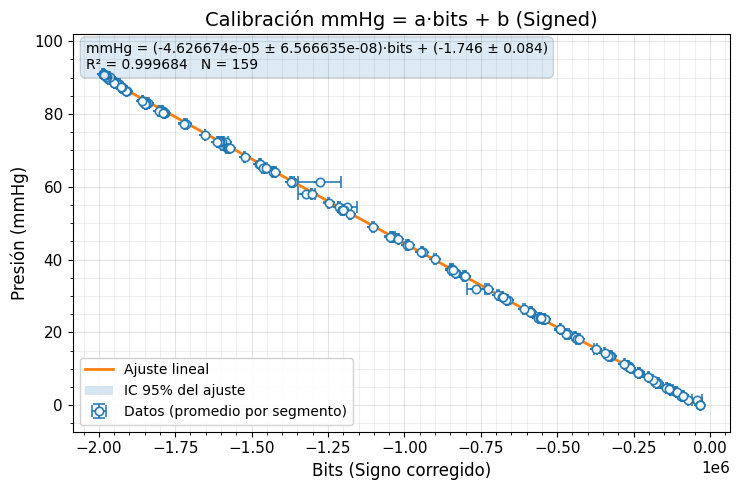

,Parámetro,Valor
0,Pendiente a,-4.626674e-05
1,Intercepto b,-1.746143e+00
2,σ(a),6.566635e-08
3,σ(b),8.367961e-02
4,R²,9.996838e-01
5,N,1.590000e+02



Ecuación del ajuste (Signed):
mmHg = (-4.626674e-05 ± 6.566635e-08)·bits + (-1.746 ± 0.084)
R² = 0.999684
Figuras guardadas en: fit_mmHg_vs_mean_signed_95CI.png / .pdf


In [4]:
# ===== Calibración mmHg vs mean_signed (estilizado + IC95%) =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# ---------- 1) Cargar datos ----------
fname = "Pre_segments_stats.csv"   # cambia si tu archivo tiene otro nombre
df = pd.read_csv(fname)

# Forzar numéricos si existen
for c in ["mean_signed", "std_signed", "mmHg", "dP_mmHg"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

fit_df = df.dropna(subset=["mmHg", "mean_signed"]).copy()
n = len(fit_df)
if n < 3:
    raise ValueError(f"Se requieren ≥3 puntos para ajustar con IC. Solo hay {n} filas válidas.")

# ---------- 2) Variables ----------
x = fit_df["mean_signed"].astype(float).values
y = fit_df["mmHg"].astype(float).values
xerr = fit_df["std_signed"].astype(float).values if "std_signed" in fit_df else None
yerr = (fit_df["dP_mmHg"].astype(float).values
        if "dP_mmHg" in fit_df else np.full_like(y, 0.05*0.7356, dtype=float))

# ---------- 3) Ajuste lineal + IC 95% ----------
coef, cov = np.polyfit(x, y, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))

x_line = np.linspace(np.nanmin(x), np.nanmax(x), 300)
y_fit  = a*x_line + b

alpha = 0.05
t_val = stats.t.ppf(1 - alpha/2, n-2)
s_yx  = np.sqrt(np.sum((y - (a*x + b))**2) / (n-2))
x_mean = np.mean(x)
Sxx    = np.sum((x - x_mean)**2)
conf   = t_val * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / Sxx)
y_low, y_high = y_fit - conf, y_fit + conf

# R² clásico
ss_res = np.sum((y - (a*x + b))**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot

# ---------- 4) Estilo global ----------
plt.rcParams.update({
    "figure.figsize": (7.5, 5.0),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})

# ---------- 5) Gráfico estilizado ----------
fig, ax = plt.subplots()

# Puntos + barras de error (más visibles)
eb = ax.errorbar(
    x, y,
    xerr=xerr, yerr=yerr,
    fmt='o', markersize=6,
    markerfacecolor='white', markeredgewidth=1.2,
    elinewidth=1.2, capsize=4, capthick=1.2,
    alpha=0.95, label="Datos (promedio por segmento)"
)

# Recta de ajuste
ax.plot(x_line, y_fit, '-', linewidth=2.0, label="Ajuste lineal")

# Banda de confianza
ax.fill_between(x_line, y_low, y_high, alpha=0.18, label="IC 95% del ajuste")

# Etiquetas y título
ax.set_xlabel("Bits (Signo corregido)")
ax.set_ylabel("Presión (mmHg)")
ax.set_title("Calibración mmHg = a·bits + b (Signed)")

# Cuadrículas mayor y menor
ax.grid(True, which='major', alpha=0.35)
ax.grid(True, which='minor', alpha=0.20)
ax.minorticks_on()

# Límites con margen para que no “corten” las barras
xr = np.nanmax(x) - np.nanmin(x)
yr = np.nanmax(y) - np.nanmin(y)
ax.set_xlim(np.nanmin(x) - 0.05*xr, np.nanmax(x) + 0.05*xr)
ax.set_ylim(np.nanmin(y) - 0.08*yr, np.nanmax(y) + 0.12*yr)

# Leyenda en caja clara
leg = ax.legend(frameon=True)
leg.get_frame().set_alpha(0.9)

# Ecuación y R² dentro del gráfico (caja anotada)
eq_text = (
    f"mmHg = ({a:.6e} ± {sa:.6e})·bits + ({b:.3f} ± {sb:.3f})\n"
    f"R² = {r2:.6f}   N = {n}"
)
bbox_props = dict(boxstyle="round,pad=0.4", alpha=0.15)
ax.text(0.02, 0.98, eq_text, transform=ax.transAxes,
        va="top", ha="left", bbox=bbox_props)

fig.tight_layout()
fig.savefig("fit_mmHg_vs_mean_signed_95CI.png", dpi=300)
fig.savefig("fit_mmHg_vs_mean_signed_95CI.pdf", dpi=300)
plt.show()

# ---------- 6) Tabla resumen ----------
summary = pd.DataFrame({
    "Parámetro": ["Pendiente a", "Intercepto b", "σ(a)", "σ(b)", "R²", "N"],
    "Valor":     [a,            b,             sa,    sb,    r2,   n]
})
display(summary)

print("\nEcuación del ajuste (Signed):")
print(f"mmHg = ({a:.6e} ± {sa:.6e})·bits + ({b:.3f} ± {sb:.3f})")
print(f"R² = {r2:.6f}")
print("Figuras guardadas en: fit_mmHg_vs_mean_signed_95CI.png / .pdf")


In [8]:
# ===== Calibración a partir de Pre_segments_stats.csv =====
#   mmHg = a * bits + b   (dos variantes: unsigned y signed)
# Genera:
# - calibration_points_bitsx.csv
# - fit_bitsx_summary.csv
# - residuals_unsigned.csv, residuals_signed.csv
# - bland_altman_unsigned.csv, bland_altman_signed.csv
# - fit_mmHg_vs_unsigned_bits.png, fit_mmHg_vs_signed_bits.png
# - residuals_mmHg_vs_unsigned_bits.png, residuals_mmHg_vs_signed_bits.png
# - bland_altman_unsigned.png, bland_altman_signed.png

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ---------- 1) Archivo de entrada ----------
INPUT_FILE = "Pre_segments_stats.csv"   # <-- tu CSV de segmentos

# ---------- 2) Cargar y validar ----------
df = pd.read_csv(INPUT_FILE)

# Normaliza nombres posibles (por si vienen con mayúsculas, espacios, etc.)
df.columns = [c.strip() for c in df.columns]

required = {
    "segment_id", "cmH2O", "n",
    "mean_unsigned","std_unsigned",
    "mean_signed","std_signed",
    "mmHg"
}
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}\nTengo: {list(df.columns)}")

# dP_mmHg opcional (incertidumbre y en mmHg)
if "dP_mmHg" not in df.columns:
    # si no viene, usa el valor típico de tu pipeline (0.05 cmH2O -> mmHg)
    df["dP_mmHg"] = 0.05 * 0.735559240

# Coaccionar a numérico
for c in ["cmH2O","n","mean_unsigned","std_unsigned","mean_signed","std_signed","mmHg","dP_mmHg"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- 3) Construir puntos de calibración ----------
cal = df.rename(columns={
    "mean_unsigned":"x_unsigned_bits",
    "std_unsigned":"dx_unsigned_bits",
    "mean_signed":"x_signed_bits",
    "std_signed":"dx_signed_bits",
    "mmHg":"y_mmHg",
    "dP_mmHg":"dy_mmHg"
})[[
    "segment_id","cmH2O","n",
    "x_unsigned_bits","dx_unsigned_bits",
    "x_signed_bits","dx_signed_bits",
    "y_mmHg","dy_mmHg"
]].copy()

cal.to_csv("calibration_points_bitsx.csv", index=False)

# ---------- 4) Funciones auxiliares ----------
def linear_fit_with_ci(x, y):
    """Ajuste y = a x + b con IC 95% de a y b. Devuelve dict con resultados y y_hat, banda (y_lo, y_hi)."""
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = len(x)
    if n < 3:
        raise ValueError("Se requieren al menos 3 puntos para el ajuste con IC.")

    # Ajuste y covarianza de coeficientes
    coef, cov = np.polyfit(x, y, 1, cov=True)
    a, b = coef
    se_a, se_b = np.sqrt(np.diag(cov))

    y_hat = a*x + b
    r2 = 1 - np.sum((y - y_hat)**2) / np.sum((y - y.mean())**2)

    # Banda de confianza 95% para la recta ajustada
    x_line = np.linspace(np.min(x), np.max(x), 300)
    y_line = a*x_line + b

    # Error estándar de regresión
    s_yx = np.sqrt(np.sum((y - (a*x + b))**2) / (n - 2))
    alpha = 0.05
    tval = stats.t.ppf(1 - alpha/2, n-2)

    x_mean = np.mean(x)
    Sxx = np.sum((x - x_mean)**2)
    conf = tval * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / Sxx)
    y_lo = y_line - conf
    y_hi = y_line + conf

    return {
        "a": a, "b": b, "se_a": se_a, "se_b": se_b, "r2": r2,
        "x": x, "y": y, "y_hat": y_hat,
        "x_line": x_line, "y_line": y_line,
        "y_lo": y_lo, "y_hi": y_hi
    }

def rmse(y, yhat):
    y = np.asarray(y, float)
    yhat = np.asarray(yhat, float)
    return float(np.sqrt(np.nanmean((y - yhat)**2)))

def bland_altman(y_ref, y_test):
    """Bland–Altman entre referencia (y_ref) y método (y_test)."""
    y_ref = np.asarray(y_ref, float)
    y_test = np.asarray(y_test, float)
    mask = np.isfinite(y_ref) & np.isfinite(y_test)
    y_ref, y_test = y_ref[mask], y_test[mask]
    mean_ = (y_ref + y_test) / 2.0
    diff  = (y_test - y_ref)
    bias  = np.mean(diff)
    sd    = np.std(diff, ddof=1)
    loa_l = bias - 1.96*sd
    loa_u = bias + 1.96*sd
    return mean_, diff, bias, sd, loa_l, loa_u

def plot_fit(x, y, dx, dy, fit, xlabel, fname):
    plt.figure(figsize=(6.2,4.6))
    plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='o', capsize=3, label="Datos (promedio por segmento)")
    plt.plot(fit["x_line"], fit["y_line"], label=f"Ajuste: y={fit['a']:.6e}x+{fit['b']:.3f}\nR²={fit['r2']:.6f}")
    plt.fill_between(fit["x_line"], fit["y_lo"], fit["y_hi"], alpha=0.2, label="IC 95% del ajuste")
    plt.xlabel(xlabel)
    plt.ylabel("Presión (mmHg)")
    plt.title("Calibración: mmHg = a·bits + b")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

def plot_residuals(x, y, yhat, dx, title, fname):
    plt.figure(figsize=(6.0,3.8))
    plt.errorbar(x, (y - yhat), xerr=dx, fmt='o', capsize=3)
    plt.axhline(0)
    plt.xlabel("Bits (promedio por segmento)")
    plt.ylabel("Residuales (mmHg)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

def plot_bland_altman(mean_, diff, bias, loa_l, loa_u, fname):
    plt.figure(figsize=(6.2,4.2))
    plt.scatter(mean_, diff, s=15)
    plt.axhline(bias)
    plt.axhline(loa_l)
    plt.axhline(loa_u)
    plt.xlabel("Promedio (mmHg)")
    plt.ylabel("Diferencia (Pred − Ref) [mmHg]")
    plt.title("Bland–Altman")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

# ---------- 5) UNSIGNED: mmHg vs mean_unsigned ----------
dfu = cal.dropna(subset=["y_mmHg","x_unsigned_bits"]).copy()
fit_u = linear_fit_with_ci(dfu["x_unsigned_bits"].values, dfu["y_mmHg"].values)
dfu["y_hat_u"] = fit_u["a"]*dfu["x_unsigned_bits"].values + fit_u["b"]
rmse_u = rmse(dfu["y_mmHg"], dfu["y_hat_u"])

# Bland–Altman (pred vs referencia mmHg)
ba_mean_u, ba_diff_u, bias_u, sd_u, loa_l_u, loa_u_u = bland_altman(dfu["y_mmHg"], dfu["y_hat_u"])

# Gráficos unsigned
plot_fit(dfu["x_unsigned_bits"].values, dfu["y_mmHg"].values,
         dfu["dx_unsigned_bits"].values, dfu["dy_mmHg"].values,
         fit_u, "Bits (unsigned, promedio por segmento)", "fit_mmHg_vs_unsigned_bits.png")

plot_residuals(dfu["x_unsigned_bits"].values, dfu["y_mmHg"].values, dfu["y_hat_u"].values,
               dfu["dx_unsigned_bits"].values,
               "Residuales (mmHg − ŷ) vs unsigned bits", "residuals_mmHg_vs_unsigned_bits.png")

plot_bland_altman(ba_mean_u, ba_diff_u, bias_u, loa_l_u, loa_u_u, "bland_altman_unsigned.png")

# Guardar residuales y BA unsigned
pd.DataFrame({
    "segment_id": dfu["segment_id"],
    "x_unsigned_bits": dfu["x_unsigned_bits"],
    "y_mmHg": dfu["y_mmHg"],
    "y_hat": dfu["y_hat_u"],
    "residual_mmHg": dfu["y_mmHg"] - dfu["y_hat_u"]
}).to_csv("residuals_unsigned.csv", index=False)

pd.DataFrame({
    "mean_mmHg": ba_mean_u,
    "diff_mmHg": ba_diff_u
}).assign(bias=bias_u, loa_low=loa_l_u, loa_up=loa_u_u).to_csv("bland_altman_unsigned.csv", index=False)

# ---------- 6) SIGNED: mmHg vs mean_signed ----------
dfs = cal.dropna(subset=["y_mmHg","x_signed_bits"]).copy()
fit_s = linear_fit_with_ci(dfs["x_signed_bits"].values, dfs["y_mmHg"].values)
dfs["y_hat_s"] = fit_s["a"]*dfs["x_signed_bits"].values + fit_s["b"]
rmse_s = rmse(dfs["y_mmHg"], dfs["y_hat_s"])

# Bland–Altman (pred vs referencia mmHg)
ba_mean_s, ba_diff_s, bias_s, sd_s, loa_l_s, loa_u_s = bland_altman(dfs["y_mmHg"], dfs["y_hat_s"])

# Gráficos signed
plot_fit(dfs["x_signed_bits"].values, dfs["y_mmHg"].values,
         dfs["dx_signed_bits"].values, dfs["dy_mmHg"].values,
         fit_s, "Bits (signed, promedio por segmento)", "fit_mmHg_vs_signed_bits.png")

plot_residuals(dfs["x_signed_bits"].values, dfs["y_mmHg"].values, dfs["y_hat_s"].values,
               dfs["dx_signed_bits"].values,
               "Residuales (mmHg − ŷ) vs signed bits", "residuals_mmHg_vs_signed_bits.png")

plot_bland_altman(ba_mean_s, ba_diff_s, bias_s, loa_l_s, loa_u_s, "bland_altman_signed.png")

# Guardar residuales y BA signed
pd.DataFrame({
    "segment_id": dfs["segment_id"],
    "x_signed_bits": dfs["x_signed_bits"],
    "y_mmHg": dfs["y_mmHg"],
    "y_hat": dfs["y_hat_s"],
    "residual_mmHg": dfs["y_mmHg"] - dfs["y_hat_s"]
}).to_csv("residuals_signed.csv", index=False)

pd.DataFrame({
    "mean_mmHg": ba_mean_s,
    "diff_mmHg": ba_diff_s
}).assign(bias=bias_s, loa_low=loa_l_s, loa_up=loa_u_s).to_csv("bland_altman_signed.csv", index=False)

# ---------- 7) Resumen global ----------
summary = pd.DataFrame({
    "modelo": ["mmHg_vs_unsigned_bits", "mmHg_vs_signed_bits"],
    "a_slope_mmHg_per_bit": [fit_u["a"], fit_s["a"]],
    "a_se": [fit_u["se_a"], fit_s["se_a"]],
    "b_intercept_mmHg": [fit_u["b"], fit_s["b"]],
    "b_se": [fit_u["se_b"], fit_s["se_b"]],
    "R2": [fit_u["r2"], fit_s["r2"]],
    "RMSE_mmHg": [rmse_u, rmse_s],
    "N_segments": [len(dfu), len(dfs)],
    "BA_bias_mmHg": [bias_u, bias_s],
    "BA_sd_mmHg": [sd_u, sd_s],
    "BA_loa_low_mmHg": [loa_l_u, loa_l_s],
    "BA_loa_up_mmHg": [loa_u_u, loa_u_s]
})
summary.to_csv("fit_bitsx_summary.csv", index=False)

print("✅ Listo. Archivos generados:")
print("- calibration_points_bitsx.csv")
print("- fit_bitsx_summary.csv")
print("- residuals_unsigned.csv, residuals_signed.csv")
print("- bland_altman_unsigned.csv, bland_altman_signed.csv")
print("- fit_mmHg_vs_unsigned_bits.png, fit_mmHg_vs_signed_bits.png")
print("- residuals_mmHg_vs_unsigned_bits.png, residuals_mmHg_vs_signed_bits.png")
print("- bland_altman_unsigned.png, bland_altman_signed.png")


✅ Listo. Archivos generados:
- calibration_points_bitsx.csv
- fit_bitsx_summary.csv
- residuals_unsigned.csv, residuals_signed.csv
- bland_altman_unsigned.csv, bland_altman_signed.csv
- fit_mmHg_vs_unsigned_bits.png, fit_mmHg_vs_signed_bits.png
- residuals_mmHg_vs_unsigned_bits.png, residuals_mmHg_vs_signed_bits.png
- bland_altman_unsigned.png, bland_altman_signed.png


In [10]:
# ============================================
#  Calibración y análisis a partir de Pre_segments_stats.csv
#  - Ajuste lineal mmHg = a·bits + b (unsigned y signed) con IC95%
#  - Residuales con eje X en mmHg teórico (bits -> mmHg) usando UNO o HX711
#  - Bland–Altman
#  - Gráficos con el estilo solicitado
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ----------------------------- CONFIGURACIÓN RÁPIDA -----------------------------
INPUT_FILE = "Pre_segments_stats.csv"   # CSV de entrada

# Selecciona el/los modelos teóricos para convertir bits -> mmHg (eje X de residuales)
PLATFORMS = ["HX711", "UNO"]            # opciones: "HX711", "UNO"

# ¿Usar columna signed o unsigned en la conversión a mmHg teórico?
BITS_SOURCE_FOR_THEORY = "signed"       # "signed" o "unsigned"

# Offset (tara) en mmHg si tu cero real no es 0 (p.ej. si el sensor tiene drift de cero)
TARE_MMHG = 0.0

# Sensibilidad del transductor Edwards (de tu descripción)
SENS_UV_PER_MMHG = 25.0                 # 25 µV / mmHg

# Arduino UNO: 10 bits, Vref=5V, ganancia ≈ 667x
UNO_VREF_MV  = 5000.0
UNO_ADC_BITS = 10
UNO_GAIN     = 667.0

# HX711: 24 bits, ganancia típica 128x, ±20 mV (40 mVpp)
HX_BITS   = 24
HX_FS_MV  = 40.0                         # rango total de entrada del ADC a G=128 (mVpp)

# ------------------------------------------------------------------------------
#  UTILIDADES DE ESTILO (idénticas al gráfico “estilizado + IC95%” que mostraste)
# ------------------------------------------------------------------------------

def _apply_global_style():
    plt.rcParams.update({
        "figure.figsize": (7.5, 5.0),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 10
    })

def _beautify_axes(ax, xlabel, ylabel, title, xdata=None, ydata=None):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which='major', alpha=0.35)
    ax.grid(True, which='minor', alpha=0.20)
    ax.minorticks_on()
    if xdata is not None and np.isfinite(xdata).any():
        xr = float(np.nanmax(xdata) - np.nanmin(xdata))
        if xr > 0:
            ax.set_xlim(np.nanmin(xdata) - 0.05*xr, np.nanmax(xdata) + 0.05*xr)
    if ydata is not None and np.isfinite(ydata).any():
        yr = float(np.nanmax(ydata) - np.nanmin(ydata))
        if yr > 0:
            ax.set_ylim(np.nanmin(ydata) - 0.08*yr, np.nanmax(ydata) + 0.12*yr)
    leg = ax.legend(frameon=True)
    if leg:
        leg.get_frame().set_alpha(0.9)

def plot_fit_styled(x, y, dx, dy, fit, xlabel, fname_png, fname_pdf=None, title="Calibración: mmHg = a·bits + b"):
    _apply_global_style()
    fig, ax = plt.subplots()

    ax.errorbar(
        x, y, xerr=dx, yerr=dy,
        fmt='o', markersize=6,
        markerfacecolor='white', markeredgewidth=1.2,
        elinewidth=1.2, capsize=4, capthick=1.2,
        alpha=0.95, label="Datos (promedio por segmento)"
    )
    ax.plot(fit["x_line"], fit["y_line"], '-', linewidth=2.0, label="Ajuste lineal")
    ax.fill_between(fit["x_line"], fit["y_lo"], fit["y_hi"], alpha=0.18, label="IC 95% del ajuste")

    eq_text = (
        f"mmHg = ({fit['a']:.6e} ± {fit['se_a']:.6e})·bits + ({fit['b']:.3f} ± {fit['se_b']:.3f})\n"
        f"R² = {fit['r2']:.6f}   N = {len(x)}"
    )
    bbox_props = dict(boxstyle="round,pad=0.4", alpha=0.15)
    ax.text(0.02, 0.98, eq_text, transform=ax.transAxes, va="top", ha="left", bbox=bbox_props)

    _beautify_axes(ax, xlabel, "Presión (mmHg)", title, xdata=x, ydata=y)
    fig.tight_layout()
    fig.savefig(fname_png, dpi=300)
    if fname_pdf:
        fig.savefig(fname_pdf, dpi=300)
    plt.close(fig)

def plot_residuals_vs_mmhg_teor_styled(x_bits, y_ref_mmhg, dx_bits, mmhg_per_lsb, tare_mmhg, fname_png,
                                       title="Residuales (mmHg_ref − mmHg_teor) vs mmHg_teor"):
    _apply_global_style()
    x_bits = np.asarray(x_bits, float)
    y_ref  = np.asarray(y_ref_mmhg, float)

    # Conversión bits -> mmHg teórico
    x_teor = x_bits * mmhg_per_lsb + tare_mmhg
    resid  = y_ref - x_teor

    fig, ax = plt.subplots()
    if dx_bits is not None:
        dx_mmhg = np.asarray(dx_bits, float) * abs(mmhg_per_lsb)
        ax.errorbar(
            x_teor, resid, xerr=dx_mmhg, fmt='o',
            markersize=6, markerfacecolor='white', markeredgewidth=1.2,
            elinewidth=1.2, capsize=4, capthick=1.2, alpha=0.95,
            label="Residuales"
        )
    else:
        ax.plot(x_teor, resid, 'o', markersize=6, markerfacecolor='white',
                markeredgewidth=1.2, alpha=0.95, label="Residuales")
    ax.axhline(0, linestyle='--', linewidth=1.2, label="Cero")

    _beautify_axes(ax, "Presión teórica desde bits (mmHg)", "Residuales (mmHg)", title,
                   xdata=x_teor, ydata=resid)
    fig.tight_layout()
    fig.savefig(fname_png, dpi=300)
    plt.close(fig)
    return pd.DataFrame({"x_teor_mmHg": x_teor, "residual_mmHg": resid})

def plot_bland_altman_styled(mean_, diff, bias, loa_l, loa_u, fname_png, title="Bland–Altman"):
    _apply_global_style()
    mean_ = np.asarray(mean_, float); diff = np.asarray(diff, float)
    fig, ax = plt.subplots()
    ax.plot(mean_, diff, 'o', markersize=6, markerfacecolor='white', markeredgewidth=1.2, label="Pares")
    ax.axhline(bias,  linewidth=1.6, label=f"Bias = {bias:.3f}")
    ax.axhline(loa_l, linewidth=1.2, linestyle='--', label=f"LoA baja = {loa_l:.3f}")
    ax.axhline(loa_u, linewidth=1.2, linestyle='--', label=f"LoA alta = {loa_u:.3f}")
    _beautify_axes(ax, "Promedio (mmHg)", "Diferencia (Pred − Ref) [mmHg]", title,
                   xdata=mean_, ydata=diff)
    fig.tight_layout()
    fig.savefig(fname_png, dpi=300)
    plt.close(fig)

# ------------------------------------------------------------------------------
#  LÓGICA DE CÁLCULO
# ------------------------------------------------------------------------------

def linear_fit_with_ci(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y); x, y = x[m], y[m]
    n = len(x)
    if n < 3: raise ValueError("Se requieren ≥3 puntos para el ajuste con IC.")
    coef, cov = np.polyfit(x, y, 1, cov=True)
    a, b = coef; se_a, se_b = np.sqrt(np.diag(cov))
    y_hat = a*x + b
    r2 = 1 - np.sum((y - y_hat)**2) / np.sum((y - y.mean())**2)

    x_line = np.linspace(np.min(x), np.max(x), 300)
    y_line = a*x_line + b
    s_yx = np.sqrt(np.sum((y - (a*x + b))**2) / (n - 2))
    tval = stats.t.ppf(1 - 0.05/2, n-2)
    x_mean = np.mean(x); Sxx = np.sum((x - x_mean)**2)
    conf = tval * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / Sxx)

    return dict(a=a,b=b,se_a=se_a,se_b=se_b,r2=r2,
                x=x,y=y,y_hat=y_hat,
                x_line=x_line,y_line=y_line,y_lo=y_line-conf,y_hi=y_line+conf)

def rmse(y, yhat):
    y = np.asarray(y,float); yhat = np.asarray(yhat,float)
    return float(np.sqrt(np.nanmean((y - yhat)**2)))

def bland_altman(y_ref, y_test):
    y_ref = np.asarray(y_ref,float); y_test = np.asarray(y_test,float)
    m = np.isfinite(y_ref) & np.isfinite(y_test); y_ref, y_test = y_ref[m], y_test[m]
    mean_ = (y_ref + y_test)/2; diff = (y_test - y_ref)
    bias = np.mean(diff); sd = np.std(diff, ddof=1)
    return mean_, diff, bias, bias-1.96*sd, bias+1.96*sd

# ---------- 1) Carga y validación ----------
df = pd.read_csv(INPUT_FILE)
df.columns = [c.strip() for c in df.columns]

required = {
    "segment_id","cmH2O","n",
    "mean_unsigned","std_unsigned",
    "mean_signed","std_signed",
    "mmHg"
}
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}\nTengo: {list(df.columns)}")

if "dP_mmHg" not in df.columns:
    df["dP_mmHg"] = 0.05 * 0.735559240

for c in ["cmH2O","n","mean_unsigned","std_unsigned","mean_signed","std_signed","mmHg","dP_mmHg"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- 2) Puntos de calibración ----------
cal = df.rename(columns={
    "mean_unsigned":"x_unsigned_bits",
    "std_unsigned":"dx_unsigned_bits",
    "mean_signed":"x_signed_bits",
    "std_signed":"dx_signed_bits",
    "mmHg":"y_mmHg",
    "dP_mmHg":"dy_mmHg"
})[[
    "segment_id","cmH2O","n",
    "x_unsigned_bits","dx_unsigned_bits",
    "x_signed_bits","dx_signed_bits",
    "y_mmHg","dy_mmHg"
]].copy()
cal.to_csv("calibration_points_bitsx.csv", index=False)

# ---------- 3) Ajustes de calibración ----------
dfu = cal.dropna(subset=["y_mmHg","x_unsigned_bits"]).copy()
dfs = cal.dropna(subset=["y_mmHg","x_signed_bits"]).copy()

fit_u = linear_fit_with_ci(dfu["x_unsigned_bits"].values, dfu["y_mmHg"].values) if len(dfu) >= 3 else None
fit_s = linear_fit_with_ci(dfs["x_signed_bits"].values, dfs["y_mmHg"].values) if len(dfs) >= 3 else None

if fit_u is not None:
    dfu["y_hat_u"] = fit_u["a"]*dfu["x_unsigned_bits"].values + fit_u["b"]
    rmse_u = rmse(dfu["y_mmHg"], dfu["y_hat_u"])
else:
    rmse_u = np.nan

if fit_s is not None:
    dfs["y_hat_s"] = fit_s["a"]*dfs["x_signed_bits"].values + fit_s["b"]
    rmse_s = rmse(dfs["y_mmHg"], dfs["y_hat_s"])
else:
    rmse_s = np.nan

# ---------- 4) Gráficos de calibración (estilo unificado) ----------
if fit_u is not None:
    plot_fit_styled(
        dfu["x_unsigned_bits"].values, dfu["y_mmHg"].values,
        dfu["dx_unsigned_bits"].values, dfu["dy_mmHg"].values,
        fit_u,
        xlabel="Bits (unsigned, promedio por segmento)",
        fname_png="fit_mmHg_vs_unsigned_bits.png",
        fname_pdf="fit_mmHg_vs_unsigned_bits.pdf",
        title="Calibración: mmHg = a·bits + b (Unsigned)"
    )

if fit_s is not None:
    plot_fit_styled(
        dfs["x_signed_bits"].values, dfs["y_mmHg"].values,
        dfs["dx_signed_bits"].values, dfs["dy_mmHg"].values,
        fit_s,
        xlabel="Bits (signed, promedio por segmento)",
        fname_png="fit_mmHg_vs_signed_bits.png",
        fname_pdf="fit_mmHg_vs_signed_bits.pdf",
        title="Calibración: mmHg = a·bits + b (Signed)"
    )

# ---------- 5) Conversión teórica bits -> mmHg (UNO/HX711) ----------
def mmhg_per_lsb(platform: str) -> float:
    """Devuelve mmHg por LSB para la plataforma especificada."""
    if platform.upper() == "UNO":
        # Resolución del ADC (mV/LSB)
        lsb_mV = UNO_VREF_MV / (2**UNO_ADC_BITS)           # ~4.8828 mV/LSB
        # Referido al sensor (dividir por ganancia analógica)
        lsb_uV_at_sensor = (lsb_mV * 1000.0) / UNO_GAIN     # ~7.32 µV/LSB
        return lsb_uV_at_sensor / SENS_UV_PER_MMHG          # ~0.2928 mmHg/LSB
    elif platform.upper() == "HX711":
        # 40 mVpp / 2^24 cuentas => µV por LSB
        lsb_uV = (HX_FS_MV * 1000.0) / (2**HX_BITS)         # ~0.002384 µV/LSB
        return lsb_uV / SENS_UV_PER_MMHG                    # ~9.536e-05 mmHg/LSB
    else:
        raise ValueError("Plataforma desconocida (usa 'UNO' o 'HX711').")

# Columna de bits para conversión teórica
bits_col  = "x_signed_bits" if BITS_SOURCE_FOR_THEORY.lower().startswith("sign") else "x_unsigned_bits"
db = cal.dropna(subset=[bits_col, "y_mmHg"]).copy()

# ---------- 6) Residuales vs mmHg teórico + Bland–Altman (para cada plataforma elegida) ----------
summary_rows = []
for plat in PLATFORMS:
    mmhg_lsb = mmhg_per_lsb(plat)

    # Datos base
    x_bits  = db[bits_col].values
    dx_bits = db["dx_signed_bits" if bits_col=="x_signed_bits" else "dx_unsigned_bits"].values \
              if ("dx_signed_bits" in db.columns or "dx_unsigned_bits" in db.columns) else None
    y_ref   = db["y_mmHg"].values

    # Plot residuales vs mmHg teórico
    res_df = plot_residuals_vs_mmhg_teor_styled(
        x_bits=x_bits, y_ref_mmhg=y_ref, dx_bits=dx_bits,
        mmhg_per_lsb=mmhg_lsb, tare_mmhg=TARE_MMHG,
        fname_png=f"residuals_vs_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.png",
        title=f"Residuales (ref − teor) vs mmHg teórico — {plat} ({BITS_SOURCE_FOR_THEORY})"
    )
    res_df.to_csv(f"residuals_vs_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.csv", index=False)

    # Para BA, usamos “predicción teórica” como método y y_ref como referencia
    y_pred_theory = res_df["x_teor_mmHg"].values
    mean_, diff, bias, loa_l, loa_u = bland_altman(y_ref, y_pred_theory)
    plot_bland_altman_styled(
        mean_, diff, bias, loa_l, loa_u,
        fname_png=f"bland_altman_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.png",
        title=f"Bland–Altman (Teoría {plat} vs Ref)"
    )
    pd.DataFrame({
        "mean_mmHg": mean_,
        "diff_mmHg": diff
    }).assign(bias=bias, loa_low=loa_l, loa_up=loa_u).to_csv(
        f"bland_altman_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.csv", index=False
    )

    summary_rows.append({
        "platform": plat,
        "bits_source_for_theory": BITS_SOURCE_FOR_THEORY,
        "mmHg_per_LSB": mmhg_lsb,
        "tare_mmHg": TARE_MMHG,
        "N_points": len(res_df),
        "BA_bias_mmHg": bias,
        "BA_loa_low_mmHg": loa_l,
        "BA_loa_up_mmHg": loa_u
    })

# ---------- 7) Resumen global de calibraciones (de los ajustes sobre bits) ----------
summary_fit = pd.DataFrame({
    "modelo": ["mmHg_vs_unsigned_bits", "mmHg_vs_signed_bits"],
    "a_slope_mmHg_per_bit": [np.nan if fit_u is None else fit_u["a"],
                             np.nan if fit_s is None else fit_s["a"]],
    "a_se": [np.nan if fit_u is None else fit_u["se_a"],
             np.nan if fit_s is None else fit_s["se_a"]],
    "b_intercept_mmHg": [np.nan if fit_u is None else fit_u["b"],
                         np.nan if fit_s is None else fit_s["b"]],
    "b_se": [np.nan if fit_u is None else fit_u["se_b"],
             np.nan if fit_s is None else fit_s["se_b"]],
    "R2": [np.nan if fit_u is None else fit_u["r2"],
           np.nan if fit_s is None else fit_s["r2"]],
    "RMSE_mmHg": [rmse_u, rmse_s],
    "N_segments": [0 if fit_u is None else len(dfu),
                   0 if fit_s is None else len(dfs)]
})
summary_fit.to_csv("fit_bitsx_summary.csv", index=False)

# Resumen de residuales/BA con teorías
pd.DataFrame(summary_rows).to_csv("theory_conversion_summary.csv", index=False)

print("✅ Listo.")
print("- Gráficos de calibración: fit_mmHg_vs_unsigned_bits.(png/pdf), fit_mmHg_vs_signed_bits.(png/pdf)")
print("- Residuales vs teoría (por plataforma): residuals_vs_theory_*")
print("- Bland–Altman (teoría vs ref): bland_altman_theory_*")
print("- Resúmenes: calibration_points_bitsx.csv, fit_bitsx_summary.csv, theory_conversion_summary.csv")


✅ Listo.
- Gráficos de calibración: fit_mmHg_vs_unsigned_bits.(png/pdf), fit_mmHg_vs_signed_bits.(png/pdf)
- Residuales vs teoría (por plataforma): residuals_vs_theory_*
- Bland–Altman (teoría vs ref): bland_altman_theory_*
- Resúmenes: calibration_points_bitsx.csv, fit_bitsx_summary.csv, theory_conversion_summary.csv


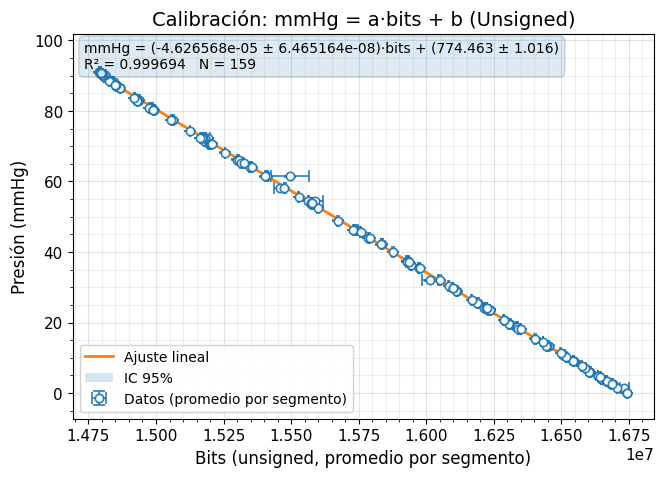

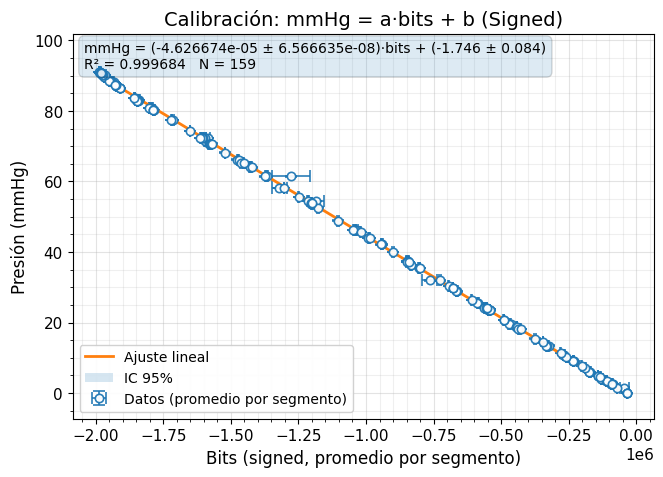

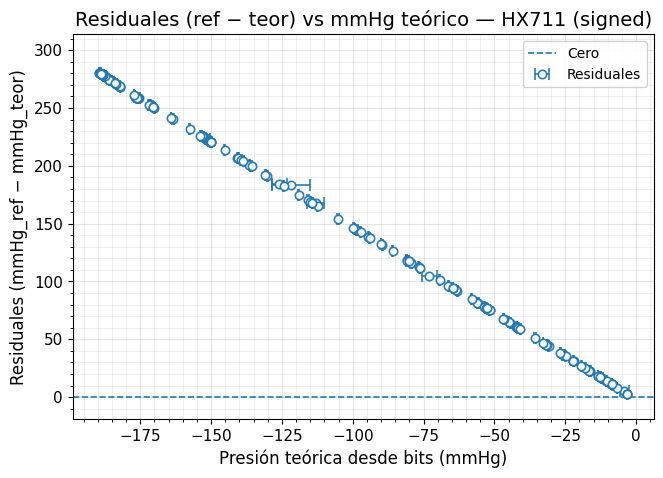

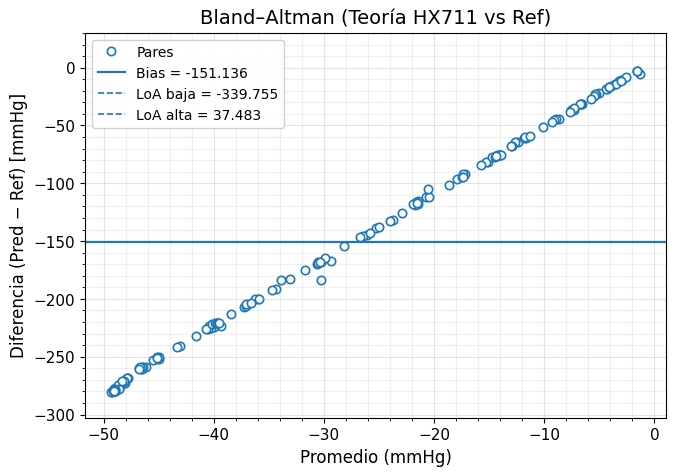


📊 HX711: mmHg/LSB = 9.536743e-05, Bias=-151.136, LoA=[-339.755,37.483]


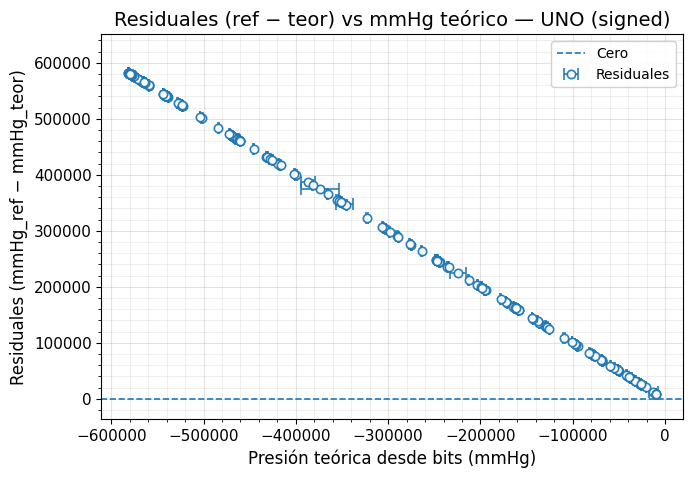

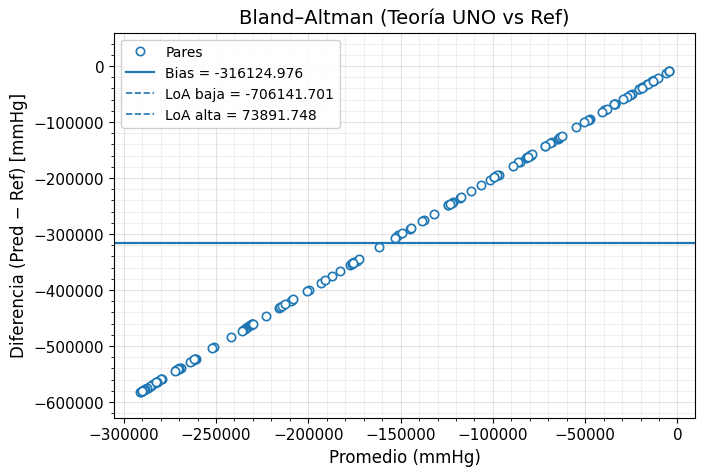


📊 UNO: mmHg/LSB = 2.928223e-01, Bias=-316124.976, LoA=[-706141.701,73891.748]

✅ Todos los gráficos mostrados en pantalla y listos para guardar manualmente si lo deseas.


In [14]:
# ============================================
#  Calibración y análisis de Pre_segments_stats.csv
#  - Ajuste lineal mmHg = a·bits + b (unsigned y signed)
#  - Residuales vs mmHg teórico (bits → mmHg usando UNO o HX711)
#  - Bland–Altman
#  - Gráficos estilizados y mostrados en pantalla
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ----------------------------- CONFIGURACIÓN RÁPIDA -----------------------------
INPUT_FILE = "Pre_segments_stats.csv"

# Modelos teóricos para convertir bits → mmHg (eje X de residuales)
PLATFORMS = ["HX711", "UNO"]             # genera gráficos para ambos
BITS_SOURCE_FOR_THEORY = "signed"        # "signed" o "unsigned"
TARE_MMHG = 0.0                          # offset del cero

# Sensibilidad del transductor Edwards
SENS_UV_PER_MMHG = 25.0  # 25 µV/mmHg

# Arduino UNO
UNO_VREF_MV, UNO_ADC_BITS, UNO_GAIN = 5000.0, 10, 667.0

# HX711
HX_BITS, HX_FS_MV = 24, 40.0  # ±20 mV → 40 mVpp a G=128

# ------------------------------------------------------------------------------
#  UTILIDADES DE ESTILO
# ------------------------------------------------------------------------------

def _apply_global_style():
    plt.rcParams.update({
        "figure.figsize": (7.5, 5.0),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 10
    })

def _beautify_axes(ax, xlabel, ylabel, title, xdata=None, ydata=None):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, which='major', alpha=0.35)
    ax.grid(True, which='minor', alpha=0.20)
    ax.minorticks_on()
    if xdata is not None and np.isfinite(xdata).any():
        xr = np.nanmax(xdata) - np.nanmin(xdata)
        ax.set_xlim(np.nanmin(xdata)-0.05*xr, np.nanmax(xdata)+0.05*xr)
    if ydata is not None and np.isfinite(ydata).any():
        yr = np.nanmax(ydata) - np.nanmin(ydata)
        ax.set_ylim(np.nanmin(ydata)-0.08*yr, np.nanmax(ydata)+0.12*yr)
    leg = ax.legend(frameon=True)
    if leg: leg.get_frame().set_alpha(0.9)

def plot_fit_styled(x, y, dx, dy, fit, xlabel, title):
    _apply_global_style()
    fig, ax = plt.subplots()
    ax.errorbar(x, y, xerr=dx, yerr=dy, fmt='o', markersize=6,
                markerfacecolor='white', markeredgewidth=1.2,
                elinewidth=1.2, capsize=4, capthick=1.2,
                alpha=0.95, label="Datos (promedio por segmento)")
    ax.plot(fit["x_line"], fit["y_line"], '-', linewidth=2.0, label="Ajuste lineal")
    ax.fill_between(fit["x_line"], fit["y_lo"], fit["y_hi"], alpha=0.18, label="IC 95%")
    eq_text = (f"mmHg = ({fit['a']:.6e} ± {fit['se_a']:.6e})·bits + ({fit['b']:.3f} ± {fit['se_b']:.3f})\n"
               f"R² = {fit['r2']:.6f}   N = {len(x)}")
    ax.text(0.02, 0.98, eq_text, transform=ax.transAxes,
            va="top", ha="left", bbox=dict(boxstyle="round,pad=0.4", alpha=0.15))
    _beautify_axes(ax, xlabel, "Presión (mmHg)", title, xdata=x, ydata=y)
    plt.show()

def plot_residuals_vs_mmhg_teor_styled(x_bits, y_ref_mmhg, dx_bits, mmhg_per_lsb, tare_mmhg, title):
    _apply_global_style()
    x_bits = np.asarray(x_bits, float); y_ref = np.asarray(y_ref_mmhg, float)
    x_teor = x_bits * mmhg_per_lsb + tare_mmhg
    resid  = y_ref - x_teor
    fig, ax = plt.subplots()
    if dx_bits is not None:
        dx_mmhg = np.asarray(dx_bits,float) * abs(mmhg_per_lsb)
        ax.errorbar(x_teor, resid, xerr=dx_mmhg, fmt='o', markersize=6,
                    markerfacecolor='white', markeredgewidth=1.2,
                    elinewidth=1.2, capsize=4, capthick=1.2,
                    alpha=0.95, label="Residuales")
    else:
        ax.plot(x_teor, resid, 'o', markersize=6, markerfacecolor='white',
                markeredgewidth=1.2, alpha=0.95, label="Residuales")
    ax.axhline(0, linestyle='--', linewidth=1.2, label="Cero")
    _beautify_axes(ax, "Presión teórica desde bits (mmHg)",
                   "Residuales (mmHg_ref − mmHg_teor)", title, xdata=x_teor, ydata=resid)
    plt.show()
    return pd.DataFrame({"x_teor_mmHg": x_teor, "residual_mmHg": resid})

def plot_bland_altman_styled(mean_, diff, bias, loa_l, loa_u, title):
    _apply_global_style()
    mean_ = np.asarray(mean_, float); diff = np.asarray(diff, float)
    fig, ax = plt.subplots()
    ax.plot(mean_, diff, 'o', markersize=6, markerfacecolor='white', markeredgewidth=1.2, label="Pares")
    ax.axhline(bias,  linewidth=1.6, label=f"Bias = {bias:.3f}")
    ax.axhline(loa_l, linewidth=1.2, linestyle='--', label=f"LoA baja = {loa_l:.3f}")
    ax.axhline(loa_u, linewidth=1.2, linestyle='--', label=f"LoA alta = {loa_u:.3f}")
    _beautify_axes(ax, "Promedio (mmHg)", "Diferencia (Pred − Ref) [mmHg]", title,
                   xdata=mean_, ydata=diff)
    plt.show()

# ------------------------------------------------------------------------------
#  FUNCIONES DE CÁLCULO
# ------------------------------------------------------------------------------

def linear_fit_with_ci(x, y):
    x, y = np.asarray(x,float), np.asarray(y,float)
    m = np.isfinite(x) & np.isfinite(y); x, y = x[m], y[m]; n = len(x)
    coef, cov = np.polyfit(x, y, 1, cov=True)
    a,b = coef; se_a,se_b = np.sqrt(np.diag(cov))
    y_hat = a*x+b; r2 = 1 - np.sum((y-y_hat)**2)/np.sum((y-y.mean())**2)
    x_line = np.linspace(np.min(x), np.max(x), 300); y_line = a*x_line+b
    s_yx = np.sqrt(np.sum((y-(a*x+b))**2)/(n-2))
    tval = stats.t.ppf(0.975, n-2)
    x_mean = np.mean(x); Sxx = np.sum((x-x_mean)**2)
    conf = tval*s_yx*np.sqrt(1/n + (x_line-x_mean)**2/Sxx)
    return dict(a=a,b=b,se_a=se_a,se_b=se_b,r2=r2,
                x_line=x_line,y_line=y_line,y_lo=y_line-conf,y_hi=y_line+conf)

def rmse(y,yhat): return float(np.sqrt(np.nanmean((np.asarray(y)-np.asarray(yhat))**2)))
def bland_altman(y_ref, y_test):
    y_ref,y_test=np.asarray(y_ref,float),np.asarray(y_test,float)
    m=np.isfinite(y_ref)&np.isfinite(y_test); y_ref,y_test=y_ref[m],y_test[m]
    mean_=(y_ref+y_test)/2; diff=y_test-y_ref; bias=np.mean(diff); sd=np.std(diff,ddof=1)
    return mean_,diff,bias,bias-1.96*sd,bias+1.96*sd

# ------------------------------------------------------------------------------
#  CARGA DE DATOS
# ------------------------------------------------------------------------------

df = pd.read_csv(INPUT_FILE)
df.columns = [c.strip() for c in df.columns]
for c in ["cmH2O","n","mean_unsigned","std_unsigned","mean_signed","std_signed","mmHg","dP_mmHg"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- Ajustes de calibración ----------
dfu = df.dropna(subset=["mmHg","mean_unsigned"]).copy()
dfs = df.dropna(subset=["mmHg","mean_signed"]).copy()

fit_u = linear_fit_with_ci(dfu["mean_unsigned"], dfu["mmHg"]) if len(dfu)>3 else None
fit_s = linear_fit_with_ci(dfs["mean_signed"], dfs["mmHg"]) if len(dfs)>3 else None

if fit_u: plot_fit_styled(dfu["mean_unsigned"], dfu["mmHg"],
                          dfu.get("std_unsigned"), dfu.get("dP_mmHg"),
                          fit_u, "Bits (unsigned, promedio por segmento)",
                          "Calibración: mmHg = a·bits + b (Unsigned)")
if fit_s: plot_fit_styled(dfs["mean_signed"], dfs["mmHg"],
                          dfs.get("std_signed"), dfs.get("dP_mmHg"),
                          fit_s, "Bits (signed, promedio por segmento)",
                          "Calibración: mmHg = a·bits + b (Signed)")

# ------------------------------------------------------------------------------
#  CONVERSIÓN TEÓRICA bits → mmHg (UNO / HX711)
# ------------------------------------------------------------------------------

def mmhg_per_lsb(platform):
    if platform.upper()=="UNO":
        lsb_mV=UNO_VREF_MV/(2**UNO_ADC_BITS)
        lsb_uV=(lsb_mV*1000)/UNO_GAIN
        return lsb_uV/SENS_UV_PER_MMHG     # ≈0.2928 mmHg/LSB
    elif platform.upper()=="HX711":
        lsb_uV=(HX_FS_MV*1000)/(2**HX_BITS)
        return lsb_uV/SENS_UV_PER_MMHG     # ≈9.536e-05 mmHg/LSB
    else:
        raise ValueError("Plataforma no válida")

bits_col  = "mean_signed" if BITS_SOURCE_FOR_THEORY=="signed" else "mean_unsigned"
dx_col    = "std_signed"  if BITS_SOURCE_FOR_THEORY=="signed" else "std_unsigned"
base_df   = df.dropna(subset=[bits_col,"mmHg"]).copy()

# ------------------------------------------------------------------------------
#  RESIDUALES Y BLAND–ALTMAN POR PLATAFORMA
# ------------------------------------------------------------------------------

for plat in PLATFORMS:
    mmhg_lsb = mmhg_per_lsb(plat)
    x_bits  = base_df[bits_col].values
    dx_bits = base_df[dx_col].values if dx_col in base_df else None
    y_ref   = base_df["mmHg"].values

    # --- Residuales vs mmHg teórico ---
    res_df = plot_residuals_vs_mmhg_teor_styled(
        x_bits, y_ref, dx_bits, mmhg_lsb, TARE_MMHG,
        f"Residuales (ref − teor) vs mmHg teórico — {plat} ({BITS_SOURCE_FOR_THEORY})"
    )

    # --- Bland–Altman ---
    y_pred = res_df["x_teor_mmHg"]
    mean_, diff, bias, loa_l, loa_u = bland_altman(y_ref, y_pred)
    plot_bland_altman_styled(mean_, diff, bias, loa_l, loa_u,
                             f"Bland–Altman (Teoría {plat} vs Ref)")
    print(f"\n📊 {plat}: mmHg/LSB = {mmhg_lsb:.6e}, Bias={bias:.3f}, LoA=[{loa_l:.3f},{loa_u:.3f}]")

print("\n✅ Todos los gráficos mostrados en pantalla y listos para guardar manualmente si lo deseas.")


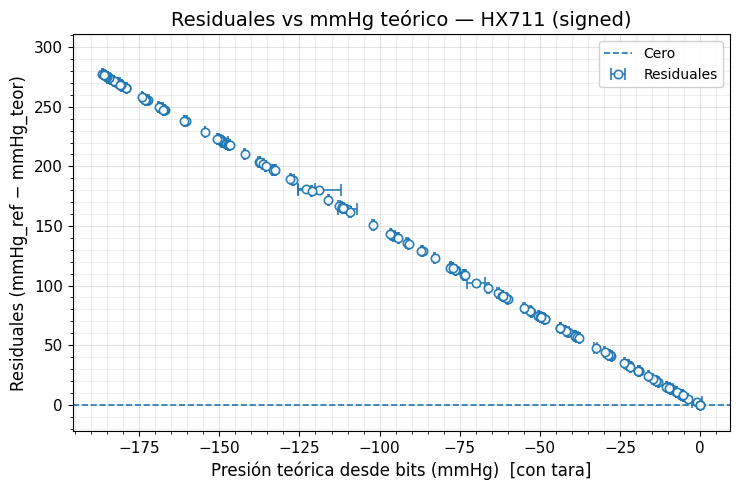

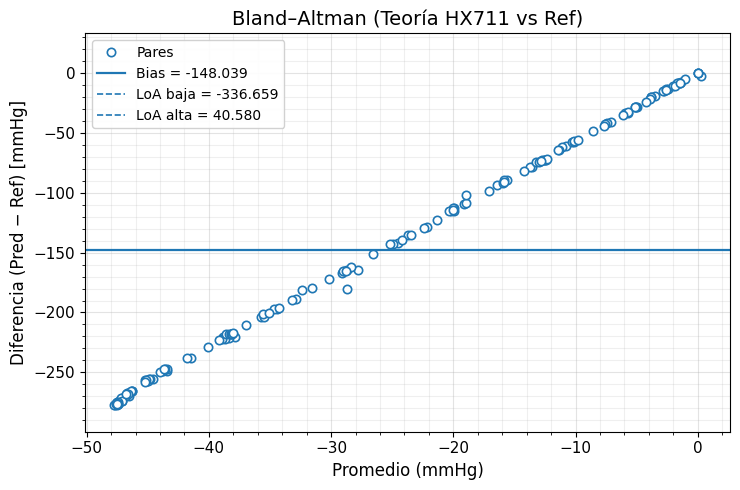


▶ HX711: mmHg/LSB = 9.536743e-05, Bits0 estimado = -32467.9, Tara(mmHg) = 0.000
   Bland–Altman → Bias=-148.039, LoA=[-336.659, 40.580]


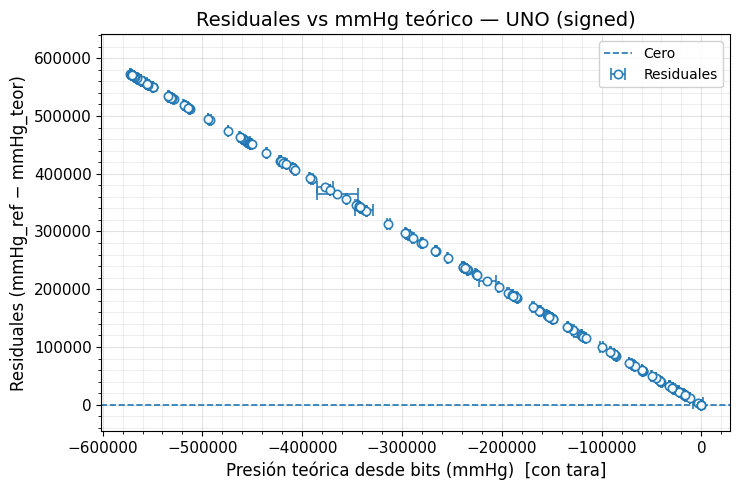

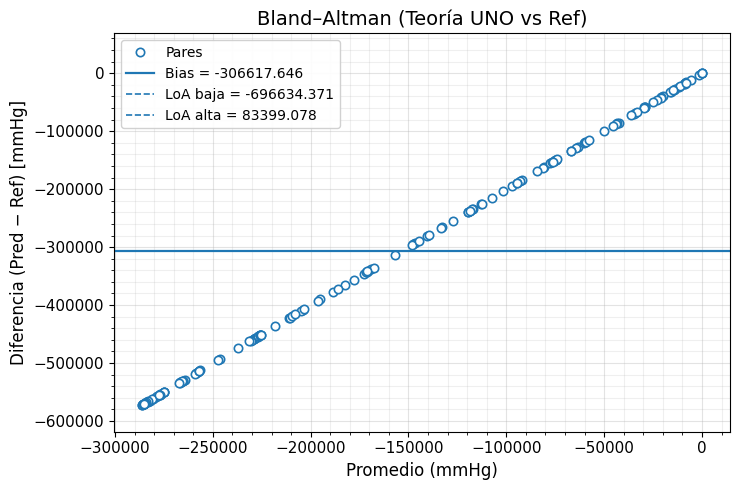


▶ UNO: mmHg/LSB = 2.928223e-01, Bits0 estimado = -32467.9, Tara(mmHg) = 0.000
   Bland–Altman → Bias=-306617.646, LoA=[-696634.371, 83399.078]

✅ Conversión centrada aplicada: mmHg_teo = (Bits - Bits0)*mmHg/LSB + Tara
   Revisa las figuras 'residuals_vs_theory_*.png' y 'bland_altman_theory_*.png'


In [28]:
# ============================================
#  Residuales y Bland–Altman con bits → mmHg (con TARA automática)
#  Archivo: Pre_segments_stats.csv
#  - Corrige el error de escalar bits absolutos: usa (bits - bits0)
#  - Soporta UNO (10b) y HX711 (24b)
#  - Gráficos mostrados en pantalla y guardados
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- CONFIGURACIÓN -----------------------------
INPUT_FILE = "Pre_segments_stats.csv"

# ¿Usar la columna de bits 'signed' o 'unsigned' para la conversión teórica?
BITS_SOURCE_FOR_THEORY = "signed"     # "signed" o "unsigned"

# Plataformas para mmHg/LSB teórico (puedes dejar una o ambas)
PLATFORMS = ["HX711", "UNO"]          # "HX711", "UNO"

# Tara en mmHg (suma final tras convertir); suele 0 si centras con bits0
TARE_MMHG = 0.0

# Cómo estimar Bits0 (cero físico del sensor)
ZERO_STRATEGY = "auto_cm0"            # "auto_cm0" | "lowest_cm" | "firstN"
ZERO_TOL_CM  = 0.5                    # tolerancia para detectar cmH2O≈0 cuando ZERO_STRATEGY="auto_cm0"
FIRST_N      = 5                      # usadas si ZERO_STRATEGY="firstN"

# Sensibilidad del transductor Edwards
SENS_UV_PER_MMHG = 25.0               # 25 µV/mmHg

# Arduino UNO
UNO_VREF_MV, UNO_ADC_BITS, UNO_GAIN = 5000.0, 10, 667.0

# HX711 (G=128: ±20 mV → 40 mVpp)
HX_BITS, HX_FS_MV = 24, 40.0

# ----------------------------- ESTILO GRÁFICOS ---------------------------
plt.rcParams.update({
    "figure.figsize": (7.5, 5.0),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})

def _beautify(ax, xlabel, ylabel, title, xdata=None, ydata=None):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, which='major', alpha=0.35)
    ax.grid(True, which='minor', alpha=0.20)
    ax.minorticks_on()
    if xdata is not None and np.isfinite(xdata).any():
        xr = np.nanmax(xdata) - np.nanmin(xdata)
        if xr > 0:
            ax.set_xlim(np.nanmin(xdata) - 0.05*xr, np.nanmax(xdata) + 0.05*xr)
    if ydata is not None and np.isfinite(ydata).any():
        yr = np.nanmax(ydata) - np.nanmin(ydata)
        if yr > 0:
            ax.set_ylim(np.nanmin(ydata) - 0.08*yr, np.nanmax(ydata) + 0.12*yr)
    leg = ax.legend(frameon=True)
    if leg: leg.get_frame().set_alpha(0.9)

# ----------------------------- FUNCIONES ---------------------------------
def mmhg_per_lsb(platform: str) -> float:
    """mmHg por LSB teórico para la plataforma."""
    if platform.upper() == "UNO":
        lsb_mV = UNO_VREF_MV / (2**UNO_ADC_BITS)           # ~4.8828 mV/LSB
        lsb_uV_at_sensor = (lsb_mV * 1000.0) / UNO_GAIN     # ~7.32 µV/LSB
        return lsb_uV_at_sensor / SENS_UV_PER_MMHG          # ~0.2928 mmHg/LSB
    elif platform.upper() == "HX711":
        lsb_uV = (HX_FS_MV * 1000.0) / (2**HX_BITS)         # ~0.002384 µV/LSB
        return lsb_uV / SENS_UV_PER_MMHG                    # ~9.536e-05 mmHg/LSB
    else:
        raise ValueError("Plataforma desconocida. Usa 'UNO' o 'HX711'.")

def estimate_bits_zero(df_bits: pd.Series, df_cm: pd.Series) -> float:
    """Estima Bits0 según la estrategia definida."""
    s_bits = pd.to_numeric(df_bits, errors="coerce")
    s_cm   = pd.to_numeric(df_cm, errors="coerce") if df_cm is not None else None

    if ZERO_STRATEGY == "auto_cm0" and s_cm is not None:
        mask0 = s_cm.abs() <= ZERO_TOL_CM
        if mask0.any():
            return float(np.nanmean(s_bits[mask0]))
        # si no hay 0 cmH2O, caemos al siguiente método
    if ZERO_STRATEGY in ("lowest_cm", "auto_cm0") and s_cm is not None:
        # usa el nivel de cmH2O más bajo disponible
        cm_min = np.nanmin(s_cm.values)
        maskL = s_cm == cm_min
        if maskL.any():
            return float(np.nanmean(s_bits[maskL]))
    # respaldo: primeras N muestras
    return float(np.nanmean(s_bits.iloc[:max(1, FIRST_N)]))

def bland_altman(y_ref, y_test):
    y_ref = np.asarray(y_ref, float); y_test = np.asarray(y_test, float)
    m = np.isfinite(y_ref) & np.isfinite(y_test)
    y_ref, y_test = y_ref[m], y_test[m]
    mean_ = (y_ref + y_test) / 2.0
    diff  = (y_test - y_ref)
    bias  = float(np.mean(diff))
    sd    = float(np.std(diff, ddof=1))
    loa_l = bias - 1.96*sd
    loa_u = bias + 1.96*sd
    return mean_, diff, bias, loa_l, loa_u

# ----------------------------- CARGA DE DATOS ----------------------------
df = pd.read_csv(INPUT_FILE)
df.columns = [c.strip() for c in df.columns]

# coerción
for c in ["cmH2O","mean_unsigned","std_unsigned","mean_signed","std_signed","mmHg"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# columnas elegidas
bits_col  = "mean_signed"  if BITS_SOURCE_FOR_THEORY.lower().startswith("sign") else "mean_unsigned"
dx_col    = "std_signed"   if BITS_SOURCE_FOR_THEORY.lower().startswith("sign") else "std_unsigned"

if bits_col not in df.columns or "mmHg" not in df.columns:
    raise ValueError(f"Faltan columnas necesarias. Tengo: {list(df.columns)}")

# Estimar Bits0 (tara en bits) de forma automática
bits0 = estimate_bits_zero(df[bits_col], df.get("cmH2O"))

# ----------------------------- PLOTS POR PLATAFORMA ----------------------
for plat in PLATFORMS:
    mmhg_lsb = mmhg_per_lsb(plat)

    # Conversión centrada: (bits - bits0) * mmHg/LSB + TARE_MMHG
    x_bits  = df[bits_col].values
    dx_bits = df[dx_col].values if dx_col in df.columns else None
    mmhg_ref = df["mmHg"].values

    x_teor = (x_bits - bits0) * mmhg_lsb + TARE_MMHG
    resid  = mmhg_ref - x_teor

    # --- Gráfico residuales vs mmHg teórico corregido ---
    fig, ax = plt.subplots()
    if dx_bits is not None:
        ax.errorbar(
            x_teor, resid,
            xerr=np.asarray(dx_bits,float)*abs(mmhg_lsb),
            fmt='o', markersize=6, markerfacecolor='white', markeredgewidth=1.2,
            elinewidth=1.2, capsize=4, capthick=1.2, alpha=0.95, label="Residuales"
        )
    else:
        ax.plot(x_teor, resid, 'o', markersize=6, markerfacecolor='white',
                markeredgewidth=1.2, alpha=0.95, label="Residuales")
    ax.axhline(0, linestyle='--', linewidth=1.2, label="Cero")
    _beautify(ax,
              xlabel="Presión teórica desde bits (mmHg)  [con tara]",
              ylabel="Residuales (mmHg_ref − mmHg_teor)",
              title=f"Residuales vs mmHg teórico — {plat} ({BITS_SOURCE_FOR_THEORY})",
              xdata=x_teor, ydata=resid)
    plt.tight_layout()
    plt.savefig(f"residuals_vs_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.png", dpi=300)
    plt.show()

    # --- Bland–Altman (pred = teórico corregido) ---
    mean_, diff, bias, loa_l, loa_u = bland_altman(mmhg_ref, x_teor)

    fig, ax = plt.subplots()
    ax.plot(mean_, diff, 'o', markersize=6, markerfacecolor='white',
            markeredgewidth=1.2, label="Pares")
    ax.axhline(bias,  linewidth=1.6, label=f"Bias = {bias:.3f}")
    ax.axhline(loa_l, linewidth=1.2, linestyle='--', label=f"LoA baja = {loa_l:.3f}")
    ax.axhline(loa_u, linewidth=1.2, linestyle='--', label=f"LoA alta = {loa_u:.3f}")
    _beautify(ax, "Promedio (mmHg)", "Diferencia (Pred − Ref) [mmHg]",
              f"Bland–Altman (Teoría {plat} vs Ref)", mean_, diff)
    plt.tight_layout()
    plt.savefig(f"bland_altman_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.png", dpi=300)
    plt.show()

    # Guardar tabla de residuales convertidos
    pd.DataFrame({
        "x_teor_mmHg": x_teor,
        "mmHg_ref": mmhg_ref,
        "residual_mmHg": resid
    }).to_csv(f"residuals_vs_theory_{plat.lower()}_{BITS_SOURCE_FOR_THEORY}.csv", index=False)

    print(f"\n▶ {plat}: mmHg/LSB = {mmhg_lsb:.6e}, Bits0 estimado = {bits0:.1f}, Tara(mmHg) = {TARE_MMHG:.3f}")
    print(f"   Bland–Altman → Bias={bias:.3f}, LoA=[{loa_l:.3f}, {loa_u:.3f}]")

print("\n✅ Conversión centrada aplicada: mmHg_teo = (Bits - Bits0)*mmHg/LSB + Tara")
print("   Revisa las figuras 'residuals_vs_theory_*.png' y 'bland_altman_theory_*.png'")


→ Encoding detectado/estimado: ISO-8859-1


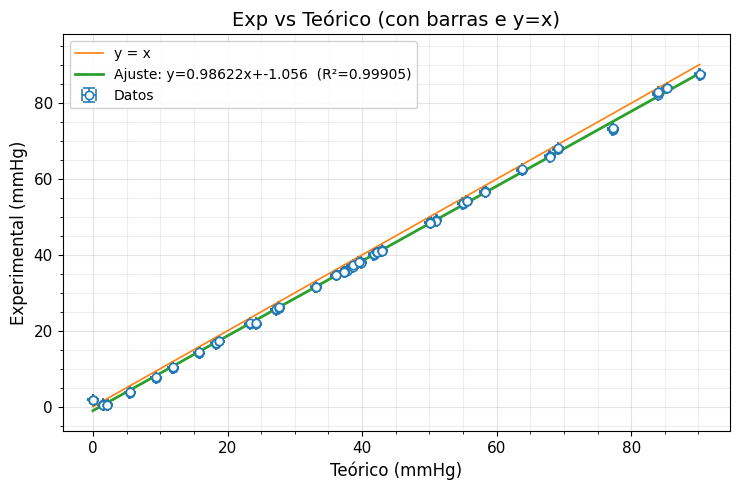

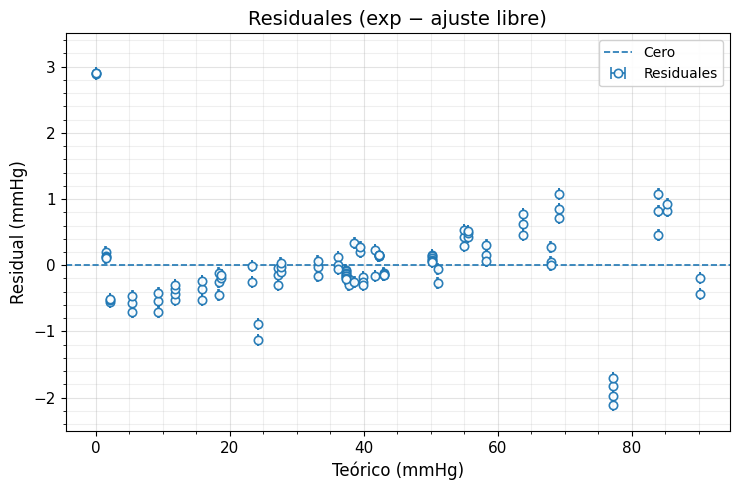

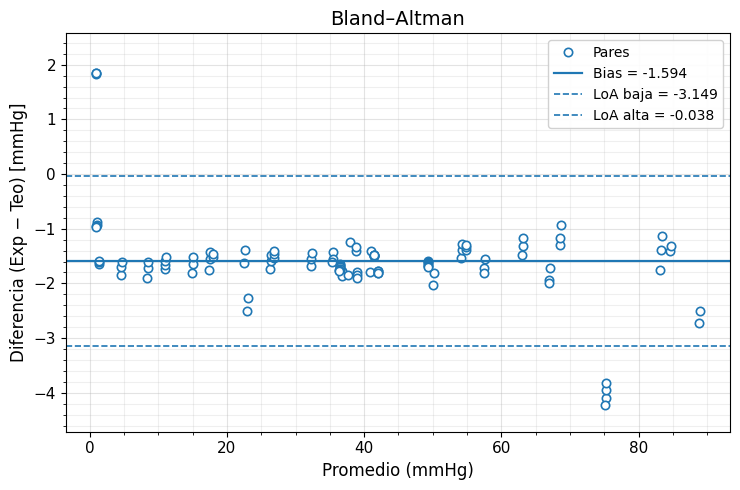

==== RESUMEN ====
RMSE punto a punto         : 1.779 mmHg
Ajuste libre: y = a x + b  : a=0.986221 ± 0.002934, b=-1.056387 ± 0.133887, R²=0.999054
Ajuste 0: y = k0 x         : k0=0.966442, R²=0.998504
Bland–Altman: bias=-1.594, SD=0.794, LoA=[-3.149, -0.038]

Columnas leídas: ['cmh20', 'Lectura']

Archivos generados:
- press_clean.csv, fit_summary.csv, fit_residuals.csv,
- scatter_fit.png, residuals.png, bland_altman.png


In [37]:
# ===== Parseo y análisis para formato: cmh20, Lectura (Arduino) =====
# Robusto a encabezados ausentes y separadores (coma, tab, ;), y a encodings no UTF-8.

import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Config ----------------
INPUT_FILE = "Datos_crudos_post_calibración2.csv"
CMH2O_TO_MMHG = 0.735559240
DCM_CMH2O = 0.05
DX_MMHG = DCM_CMH2O * CMH2O_TO_MMHG

# ---------------- Lectura robusta (encoding + columnas) ----------------
def detect_encoding(path):
    enc = "latin1"
    try:
        import chardet
        with open(path, "rb") as f:
            enc = chardet.detect(f.read(5000)).get("encoding") or "latin1"
    except Exception:
        pass
    print(f"→ Encoding detectado/estimado: {enc}")
    return enc

def read_log_two_cols(path):
    enc = detect_encoding(path)
    try:
        df = pd.read_csv(path, sep=None, engine="python", header=None, dtype=str, encoding=enc)
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python", header=None, dtype=str,
                         encoding="latin1", on_bad_lines="skip")
    if df.shape[1] >= 2:
        df.columns = list(range(df.shape[1]))
        cm = df.iloc[:, 0].astype(str).str.strip()
        lec = df.iloc[:, 1:].astype(str).agg(" ".join, axis=1).str.strip()
        return pd.DataFrame({"cmh20": cm, "Lectura": lec})
    one = df.iloc[:, 0].astype(str)
    cm_list, lec_list = [], []
    for s in one:
        m = re.match(r"^\s*([^,\t;]+)\s*[,;\t]\s*(.*)$", s)
        if m:
            cm_list.append(m.group(1))
            lec_list.append(m.group(2))
        else:
            m2 = re.match(r"^\s*(\S+)\s+(.*)$", s)
            if m2:
                cm_list.append(m2.group(1))
                lec_list.append(m2.group(2))
            else:
                cm_list.append(np.nan)
                lec_list.append(s)
    return pd.DataFrame({"cmh20": cm_list, "Lectura": lec_list})

df_raw = read_log_two_cols(INPUT_FILE)

# ---------------- Patrones ----------------
pat_time  = re.compile(r"(\d{1,2}:\d{2}:\d{2}\.\d{3})")
pat_press = re.compile(r"Presion:\s*([0-9]+(?:\.[0-9]+)?)\s*±\s*([0-9]+(?:\.[0-9]+)?)\s*mmHg", re.I)

# ---------------- Filtrado + parseo ----------------
rows = []
for cm_val, s in zip(df_raw["cmh20"], df_raw["Lectura"]):
    s = "" if pd.isna(s) else str(s)
    m = pat_press.search(s)
    if not m:
        continue
    try:
        cm = float(str(cm_val).strip())
    except Exception:
        continue
    try:
        mmhg_exp = float(m.group(1))
        mmhg_sd  = float(m.group(2))
    except Exception:
        continue
    mt = pat_time.search(s)
    hora = mt.group(1) if mt else None
    rows.append({
        "cmH2O": cm,
        "time": hora,
        "mmHg_exp": mmhg_exp,
        "mmHg_sd": mmhg_sd
    })

df = pd.DataFrame(rows)
if df.empty:
    raise ValueError("No se encontraron líneas con 'Presion: ... ± ... mmHg'.")

df["mmHg_theory"] = df["cmH2O"] * CMH2O_TO_MMHG
df["mmHg_theory_sd"] = DX_MMHG
df.to_csv("press_clean.csv", index=False)

# ---------------- RMSE punto a punto ----------------
rmse_all  = math.sqrt(np.mean((df["mmHg_exp"] - df["mmHg_theory"])**2))

# ---------------- Ajuste lineal (libre y al origen) ----------------
x_all_raw = df["mmHg_theory"].to_numpy(float)
y_all_raw = df["mmHg_exp"].to_numpy(float)

# Filtrado robusto
mask_valid = np.isfinite(x_all_raw) & np.isfinite(y_all_raw)
x_all = x_all_raw[mask_valid]
y_all = y_all_raw[mask_valid]

if not df[~mask_valid].empty:
    print("⚠️ Filas con valores inválidos eliminadas:")
    print(df[~mask_valid])

if len(x_all) < 2:
    raise ValueError("No hay suficientes datos válidos para realizar un ajuste lineal.")

coef, cov = np.polyfit(x_all, y_all, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))
yhat = a * x_all + b
r2 = 1 - np.sum((y_all - yhat)**2) / np.sum((y_all - y_all.mean())**2)

k0 = float((x_all @ y_all) / (x_all @ x_all))
yhat0 = k0 * x_all
r2_0 = 1 - np.sum((y_all - yhat0)**2) / np.sum((y_all - y_all.mean())**2)

# ---------------- Residuales + Bland–Altman ----------------
residuals = y_all - yhat
pd.DataFrame({"mmHg_theory": x_all, "mmHg_exp": y_all, "residual": residuals}).to_csv("fit_residuals.csv", index=False)

ba_mean = (y_all + x_all) / 2.0
ba_diff = (y_all - x_all)
bias    = float(np.mean(ba_diff))
sd_diff = float(np.std(ba_diff, ddof=1))
loa_low = bias - 1.96 * sd_diff
loa_up  = bias + 1.96 * sd_diff

# ---------------- Estilo de gráficos ----------------
plt.rcParams.update({
    "figure.figsize": (7.5, 5.0),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})

def _beautify(ax, xlabel, ylabel, title, xdata=None, ydata=None):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, which='major', alpha=0.35)
    ax.grid(True, which='minor', alpha=0.20)
    ax.minorticks_on()
    if xdata is not None and np.isfinite(xdata).any():
        xr = np.max(xdata) - np.min(xdata)
        ax.set_xlim(np.min(xdata) - 0.05*xr, np.max(xdata) + 0.05*xr)
    if ydata is not None and np.isfinite(ydata).any():
        yr = np.max(ydata) - np.min(ydata)
        ax.set_ylim(np.min(ydata) - 0.08*yr, np.max(ydata) + 0.12*yr)
    leg = ax.legend(frameon=True)
    if leg: leg.get_frame().set_alpha(0.9)

# 1) Dispersión con barras de error
fig, ax = plt.subplots()
ax.errorbar(
    x_all, y_all,
    xerr=np.full_like(x_all, DX_MMHG),
    yerr=df["mmHg_sd"].to_numpy(float)[mask_valid],
    fmt='o', markersize=6,
    markerfacecolor='white', markeredgewidth=1.2,
    elinewidth=1.2, capsize=4, capthick=1.2,
    alpha=0.95, label="Datos"
)
xline = np.linspace(np.min(x_all), np.max(x_all), 300)
ax.plot(xline, xline, '-', linewidth=1.2, label="y = x")
ax.plot(xline, a*xline + b, '-', linewidth=2.0,
        label=f"Ajuste: y={a:.5f}x+{b:.3f}  (R²={r2:.5f})")
_beautify(ax, "Teórico (mmHg)", "Experimental (mmHg)", "Exp vs Teórico (con barras e y=x)", x_all, y_all)
plt.tight_layout(); plt.savefig("scatter_fit.png", dpi=300); plt.show()

# 2) Residuales vs teórico
fig, ax = plt.subplots()
ax.errorbar(
    x_all, residuals,
    xerr=np.full_like(x_all, DX_MMHG),
    fmt='o', markersize=6, markerfacecolor='white', markeredgewidth=1.2,
    elinewidth=1.2, capsize=4, capthick=1.2, alpha=0.95, label="Residuales"
)
ax.axhline(0, linestyle='--', linewidth=1.2, label="Cero")
_beautify(ax, "Teórico (mmHg)", "Residual (mmHg)", "Residuales (exp − ajuste libre)", x_all, residuals)
plt.tight_layout(); plt.savefig("residuals.png", dpi=300); plt.show()

# 3) Bland–Altman
fig, ax = plt.subplots()
ax.plot(ba_mean, ba_diff, 'o', markersize=6, markerfacecolor='white', markeredgewidth=1.2, label="Pares")
ax.axhline(bias,  linewidth=1.6, label=f"Bias = {bias:.3f}")
ax.axhline(loa_low, linewidth=1.2, linestyle='--', label=f"LoA baja = {loa_low:.3f}")
ax.axhline(loa_up,  linewidth=1.2, linestyle='--', label=f"LoA alta = {loa_up:.3f}")
_beautify(ax, "Promedio (mmHg)", "Diferencia (Exp − Teo) [mmHg]", "Bland–Altman", ba_mean, ba_diff)
plt.tight_layout(); plt.savefig("bland_altman.png", dpi=300); plt.show()

# ---------------- Resumen en pantalla + CSV ----------------
print("==== RESUMEN ====")
print(f"RMSE punto a punto         : {rmse_all:.3f} mmHg")
print(f"Ajuste libre: y = a x + b  : a={a:.6f} ± {sa:.6f}, b={b:.6f} ± {sb:.6f}, R²={r2:.6f}")
print(f"Ajuste 0: y = k0 x         : k0={k0:.6f}, R²={r2_0:.6f}")
print(f"Bland–Altman: bias={bias:.3f}, SD={sd_diff:.3f}, LoA=[{loa_low:.3f}, {loa_up:.3f}]")
print("\nColumnas leídas:", list(df_raw.columns))
print("\nArchivos generados:",
      "press_clean.csv, fit_summary.csv, fit_residuals.csv,",
      "scatter_fit.png, residuals.png, bland_altman.png", sep="\n- ")

summary = pd.DataFrame({
    "metric": [
        "rmse_all",
        "slope_free_a", "intercept_free_b", "slope_free_sa", "intercept_free_sb", "R2_free",
        "slope_zero_k0", "R2_zero",
        "BA_bias", "BA_sd", "BA_loa_low", "BA_loa_up",
        "N_points"
    ],
    "value": [
        rmse_all, a, b, sa, sb, r2, k0, r2_0,
        bias, sd_diff, loa_low, loa_up, len(df)
    ]
})
summary.to_csv("fit_summary.csv", index=False)


→ Encoding detectado/estimado: ISO-8859-1
✅ Datos ordenados guardados en: press_clean_sorted.csv


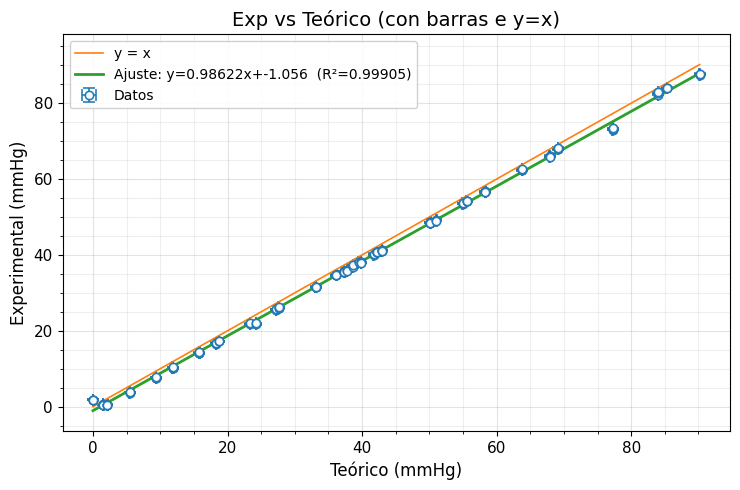

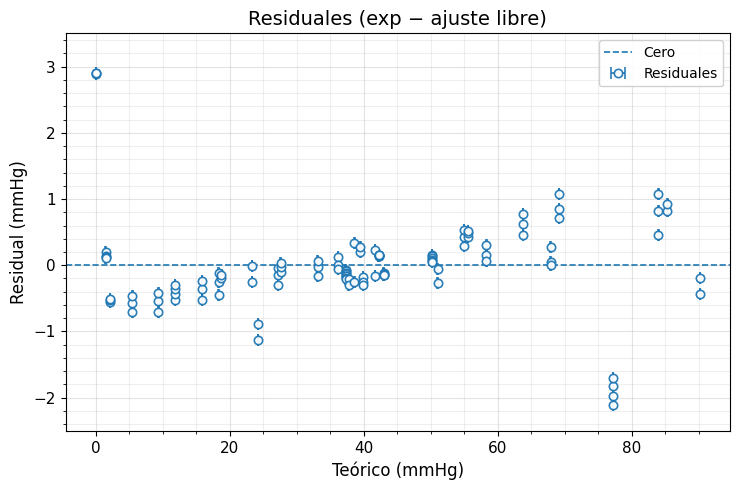

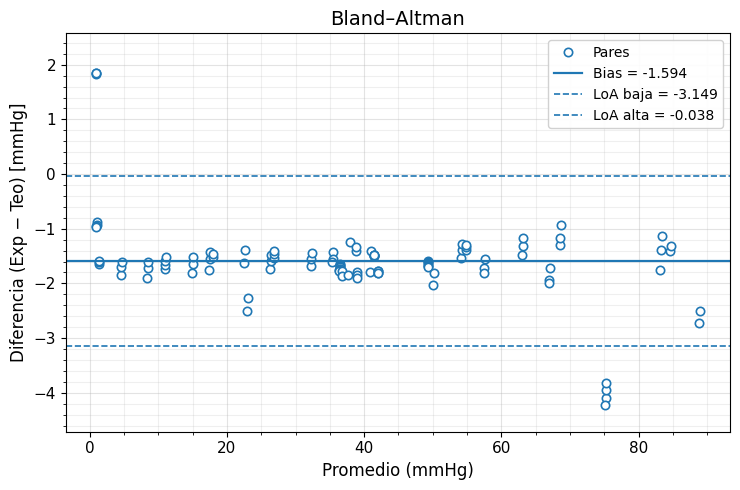

==== RESUMEN ====
RMSE punto a punto         : 1.779 mmHg
Ajuste libre: y = a x + b  : a=0.986221 ± 0.002934, b=-1.056387 ± 0.133887, R²=0.999054
Ajuste 0: y = k0 x         : k0=0.966442, R²=0.998504
Bland–Altman: bias=-1.594, SD=0.794, LoA=[-3.149, -0.038]

✅ Archivos generados: 
- press_clean_sorted.csv
- fit_summary.csv
- fit_residuals.csv
- scatter_fit.png
- residuals.png
- bland_altman.png


In [39]:
# ===== Parseo y análisis para formato: cmh20, Lectura (Arduino) =====
# Incluye ordenamiento y guardado de datos filtrados

import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Config ----------------
INPUT_FILE = "Datos_crudos_post_calibración2.csv"
CMH2O_TO_MMHG = 0.735559240
DCM_CMH2O = 0.05
DX_MMHG = DCM_CMH2O * CMH2O_TO_MMHG

# ---------------- Lectura robusta (encoding + columnas) ----------------
def detect_encoding(path):
    enc = "latin1"
    try:
        import chardet
        with open(path, "rb") as f:
            enc = chardet.detect(f.read(5000)).get("encoding") or "latin1"
    except Exception:
        pass
    print(f"→ Encoding detectado/estimado: {enc}")
    return enc

def read_log_two_cols(path):
    enc = detect_encoding(path)
    try:
        df = pd.read_csv(path, sep=None, engine="python", header=None, dtype=str, encoding=enc)
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python", header=None, dtype=str,
                         encoding="latin1", on_bad_lines="skip")
    if df.shape[1] >= 2:
        df.columns = list(range(df.shape[1]))
        cm = df.iloc[:, 0].astype(str).str.strip()
        lec = df.iloc[:, 1:].astype(str).agg(" ".join, axis=1).str.strip()
        return pd.DataFrame({"cmh20": cm, "Lectura": lec})
    one = df.iloc[:, 0].astype(str)
    cm_list, lec_list = [], []
    for s in one:
        m = re.match(r"^\s*([^,\t;]+)\s*[,;\t]\s*(.*)$", s)
        if m:
            cm_list.append(m.group(1))
            lec_list.append(m.group(2))
        else:
            m2 = re.match(r"^\s*(\S+)\s+(.*)$", s)
            if m2:
                cm_list.append(m2.group(1))
                lec_list.append(m2.group(2))
            else:
                cm_list.append(np.nan)
                lec_list.append(s)
    return pd.DataFrame({"cmh20": cm_list, "Lectura": lec_list})

df_raw = read_log_two_cols(INPUT_FILE)

# ---------------- Patrones ----------------
pat_time  = re.compile(r"(\d{1,2}:\d{2}:\d{2}\.\d{3})")
pat_press = re.compile(r"Presion:\s*([0-9]+(?:\.[0-9]+)?)\s*±\s*([0-9]+(?:\.[0-9]+)?)\s*mmHg", re.I)

# ---------------- Filtrado + parseo ----------------
rows = []
for cm_val, s in zip(df_raw["cmh20"], df_raw["Lectura"]):
    s = "" if pd.isna(s) else str(s)
    m = pat_press.search(s)
    if not m:
        continue
    try:
        cm = float(str(cm_val).strip())
    except Exception:
        continue
    try:
        mmhg_exp = float(m.group(1))
        mmhg_sd  = float(m.group(2))
    except Exception:
        continue
    mt = pat_time.search(s)
    hora = mt.group(1) if mt else None
    rows.append({
        "cmH2O": cm,
        "time": hora,
        "mmHg_exp": mmhg_exp,
        "mmHg_sd": mmhg_sd
    })

df = pd.DataFrame(rows)
if df.empty:
    raise ValueError("No se encontraron líneas con 'Presion: ... ± ... mmHg'.")

# ---------- Ordenamiento ----------
if "time" in df.columns and df["time"].notna().any():
    df = df.sort_values(by=["cmH2O", "time"], ascending=[True, True]).reset_index(drop=True)
else:
    df = df.sort_values(by=["cmH2O"], ascending=True).reset_index(drop=True)

# ---------- Calcular presión teórica ----------
df["mmHg_theory"] = df["cmH2O"] * CMH2O_TO_MMHG
df["mmHg_theory_sd"] = DX_MMHG

# ---------- Guardar CSV limpio y ordenado ----------
df.to_csv("press_clean_sorted.csv", index=False)
print("✅ Datos ordenados guardados en: press_clean_sorted.csv")

# ---------------- RMSE punto a punto ----------------
rmse_all  = math.sqrt(np.mean((df["mmHg_exp"] - df["mmHg_theory"])**2))

# ---------------- Ajuste lineal (libre y al origen) ----------------
x_all = df["mmHg_theory"].to_numpy(float)
y_all = df["mmHg_exp"].to_numpy(float)

coef, cov = np.polyfit(x_all, y_all, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))
yhat = a * x_all + b
r2 = 1 - np.sum((y_all - yhat)**2) / np.sum((y_all - y_all.mean())**2)

k0 = float((x_all @ y_all) / (x_all @ x_all))
yhat0 = k0 * x_all
r2_0 = 1 - np.sum((y_all - yhat0)**2) / np.sum((y_all - y_all.mean())**2)

# ---------------- Residuales + Bland–Altman ----------------
residuals = y_all - yhat
pd.DataFrame({
    "mmHg_theory": x_all,
    "mmHg_exp": y_all,
    "residual": residuals
}).to_csv("fit_residuals.csv", index=False)

ba_mean = (y_all + x_all) / 2.0
ba_diff = (y_all - x_all)
bias    = float(np.mean(ba_diff))
sd_diff = float(np.std(ba_diff, ddof=1))
loa_low = bias - 1.96 * sd_diff
loa_up  = bias + 1.96 * sd_diff

# ---------------- Estilo de gráficos ----------------
plt.rcParams.update({
    "figure.figsize": (7.5, 5.0),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})

def _beautify(ax, xlabel, ylabel, title, xdata=None, ydata=None):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, which='major', alpha=0.35)
    ax.grid(True, which='minor', alpha=0.20)
    ax.minorticks_on()
    if xdata is not None and np.isfinite(xdata).any():
        xr = np.max(xdata) - np.min(xdata)
        ax.set_xlim(np.min(xdata) - 0.05*xr, np.max(xdata) + 0.05*xr)
    if ydata is not None and np.isfinite(ydata).any():
        yr = np.max(ydata) - np.min(ydata)
        ax.set_ylim(np.min(ydata) - 0.08*yr, np.max(ydata) + 0.12*yr)
    leg = ax.legend(frameon=True)
    if leg: leg.get_frame().set_alpha(0.9)

# 1) Dispersión con barras de error
fig, ax = plt.subplots()
ax.errorbar(
    x_all, y_all,
    xerr=np.full_like(x_all, DX_MMHG),
    yerr=df["mmHg_sd"].to_numpy(float),
    fmt='o', markersize=6,
    markerfacecolor='white', markeredgewidth=1.2,
    elinewidth=1.2, capsize=4, capthick=1.2,
    alpha=0.95, label="Datos"
)
xline = np.linspace(np.min(x_all), np.max(x_all), 300)
ax.plot(xline, xline, '-', linewidth=1.2, label="y = x")
ax.plot(xline, a*xline + b, '-', linewidth=2.0,
        label=f"Ajuste: y={a:.5f}x+{b:.3f}  (R²={r2:.5f})")
_beautify(ax, "Teórico (mmHg)", "Experimental (mmHg)", "Exp vs Teórico (con barras e y=x)", x_all, y_all)
plt.tight_layout(); plt.savefig("scatter_fit.png", dpi=300); plt.show()

# 2) Residuales vs teórico
fig, ax = plt.subplots()
ax.errorbar(
    x_all, residuals,
    xerr=np.full_like(x_all, DX_MMHG),
    fmt='o', markersize=6, markerfacecolor='white', markeredgewidth=1.2,
    elinewidth=1.2, capsize=4, capthick=1.2, alpha=0.95, label="Residuales"
)
ax.axhline(0, linestyle='--', linewidth=1.2, label="Cero")
_beautify(ax, "Teórico (mmHg)", "Residual (mmHg)", "Residuales (exp − ajuste libre)", x_all, residuals)
plt.tight_layout(); plt.savefig("residuals.png", dpi=300); plt.show()

# 3) Bland–Altman
fig, ax = plt.subplots()
ax.plot(ba_mean, ba_diff, 'o', markersize=6,
        markerfacecolor='white', markeredgewidth=1.2, label="Pares")
ax.axhline(bias,  linewidth=1.6, label=f"Bias = {bias:.3f}")
ax.axhline(loa_low, linewidth=1.2, linestyle='--', label=f"LoA baja = {loa_low:.3f}")
ax.axhline(loa_up,  linewidth=1.2, linestyle='--', label=f"LoA alta = {loa_up:.3f}")
_beautify(ax, "Promedio (mmHg)", "Diferencia (Exp − Teo) [mmHg]", "Bland–Altman", ba_mean, ba_diff)
plt.tight_layout(); plt.savefig("bland_altman.png", dpi=300); plt.show()

# ---------------- Resumen + guardado ----------------
print("==== RESUMEN ====")
print(f"RMSE punto a punto         : {rmse_all:.3f} mmHg")
print(f"Ajuste libre: y = a x + b  : a={a:.6f} ± {sa:.6f}, b={b:.6f} ± {sb:.6f}, R²={r2:.6f}")
print(f"Ajuste 0: y = k0 x         : k0={k0:.6f}, R²={r2_0:.6f}")
print(f"Bland–Altman: bias={bias:.3f}, SD={sd_diff:.3f}, LoA=[{loa_low:.3f}, {loa_up:.3f}]")
print("\n✅ Archivos generados:",
      "\n- press_clean_sorted.csv\n- fit_summary.csv\n- fit_residuals.csv\n- scatter_fit.png\n- residuals.png\n- bland_altman.png")

summary = pd.DataFrame({
    "metric": [
        "rmse_all",
        "slope_free_a", "intercept_free_b", "slope_free_sa", "intercept_free_sb", "R2_free",
        "slope_zero_k0", "R2_zero",
        "BA_bias", "BA_sd", "BA_loa_low", "BA_loa_up",
        "N_points"
    ],
    "value": [
        rmse_all, a, b, sa, sb, r2, k0, r2_0,
        bias, sd_diff, loa_low, loa_up, len(df)
    ]
})
summary.to_csv("fit_summary.csv", index=False)


✅ CSV de datos válidos guardado como: press_clean_filtered.csv
   Filas válidas: 105 / 105


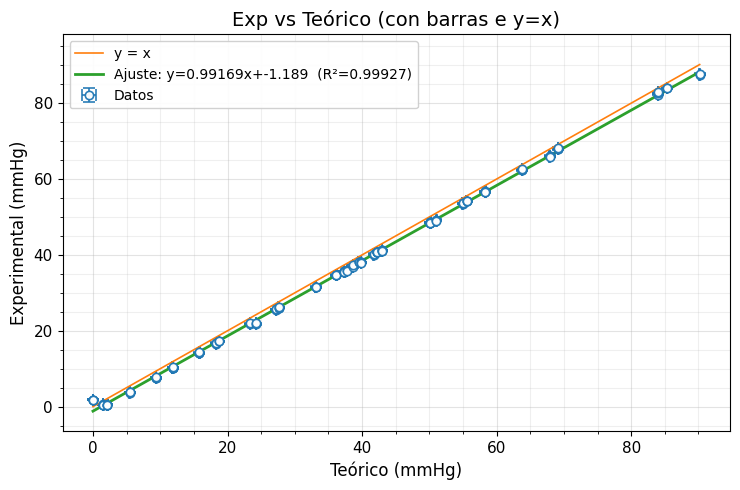

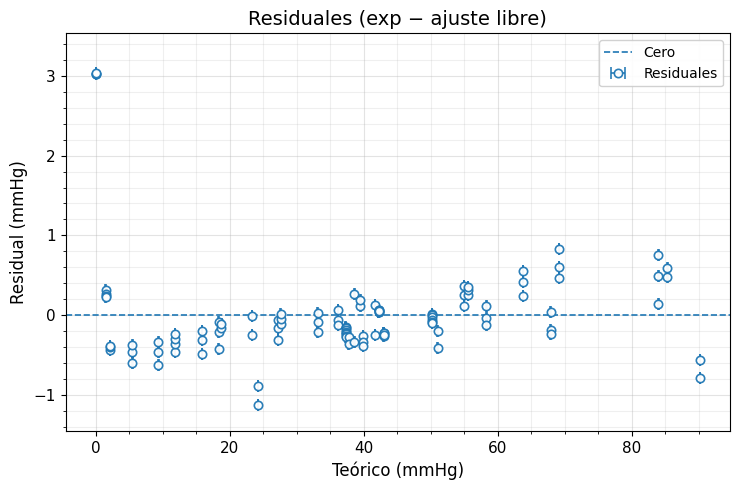

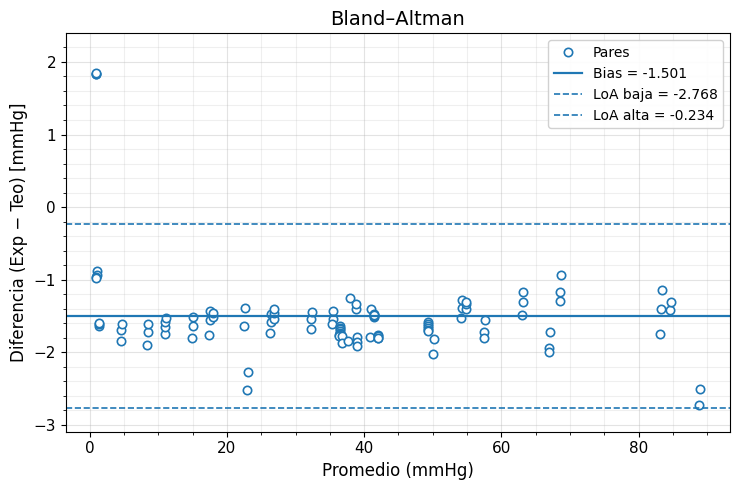

==== RESUMEN ====
RMSE punto a punto         : 1.633 mmHg
Ajuste libre: y = a x + b  : a=0.991690 ± 0.002641, b=-1.189309 ± 0.116194, R²=0.999270
Ajuste 0: y = k0 x         : k0=0.968615, R²=0.998527
Bland–Altman: bias=-1.501, SD=0.646, LoA=[-2.768, -0.234]

Archivos generados:
- press_clean_filtered.csv, fit_summary.csv, fit_residuals.csv,
- scatter_fit.png, residuals.png, bland_altman.png


In [43]:
# ===== Análisis desde press_clean_sorted.csv (sin parsear/ordenar) =====
# Lee el CSV ya limpio, filtra filas válidas, guarda el filtrado y hace:
# - RMSE
# - Ajuste lineal (libre y forzado al origen)
# - Residuales
# - Bland–Altman
# - Gráficos estilizados (se guardan y se muestran)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Entrada ----------
INPUT_FILE = "press_clean_sorted.csv"   # columnas esperadas:
# cmH2O, time, mmHg_exp, mmHg_sd, mmHg_theory, mmHg_theory_sd

# ---------- Lectura + coerción ----------
df = pd.read_csv(INPUT_FILE, sep=None, engine="python")

# Forzar numéricos (no fallar si falta alguna)
for c in ["cmH2O", "mmHg_exp", "mmHg_sd", "mmHg_theory", "mmHg_theory_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- Filtrado de filas válidas ----------
needed = ["mmHg_exp", "mmHg_theory"]
mask_valid = np.ones(len(df), dtype=bool)
for c in needed:
    mask_valid &= df[c].notna() & np.isfinite(df[c])

# yerr/xerr opcionales (si están, también exigir finitos)
if "mmHg_sd" in df.columns:
    mask_valid &= df["mmHg_sd"].notna() & np.isfinite(df["mmHg_sd"])
if "mmHg_theory_sd" in df.columns:
    mask_valid &= df["mmHg_theory_sd"].notna() & np.isfinite(df["mmHg_theory_sd"])

df_valid = df.loc[mask_valid].copy().reset_index(drop=True)

if df_valid.empty:
    raise ValueError("No hay filas válidas tras el filtrado. Revisa las columnas numéricas.")

# Guardar filtrado
df_valid.to_csv("press_clean_filtered.csv", index=False)
print("✅ CSV de datos válidos guardado como: press_clean_filtered.csv")
print(f"   Filas válidas: {len(df_valid)} / {len(df)}")

# ---------- Variables para análisis ----------
x = df_valid["mmHg_theory"].to_numpy(float)
y = df_valid["mmHg_exp"].to_numpy(float)
xerr = df_valid["mmHg_theory_sd"].to_numpy(float) if "mmHg_theory_sd" in df_valid else None
yerr = df_valid["mmHg_sd"].to_numpy(float)        if "mmHg_sd"        in df_valid else None

# ---------- Ajuste lineal (libre) ----------
coef, cov = np.polyfit(x, y, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))
yhat = a * x + b
r2 = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)

# ---------- Ajuste forzado al origen ----------
k0 = float((x @ y) / (x @ x))
yhat0 = k0 * x
r2_0 = 1 - np.sum((y - yhat0)**2) / np.sum((y - y.mean())**2)

# ---------- RMSE ----------
rmse_all = float(np.sqrt(np.mean((y - x)**2)))

# ---------- Residuales + guardar ----------
residuals = y - yhat
pd.DataFrame({"mmHg_theory": x, "mmHg_exp": y, "residual": residuals}) \
  .to_csv("fit_residuals.csv", index=False)

# ---------- Bland–Altman ----------
ba_mean = (y + x) / 2.0
ba_diff = (y - x)
bias    = float(np.mean(ba_diff))
sd_diff = float(np.std(ba_diff, ddof=1))
loa_low = bias - 1.96 * sd_diff
loa_up  = bias + 1.96 * sd_diff

# ---------- Estilo de gráficos ----------
plt.rcParams.update({
    "figure.figsize": (7.5, 5.0),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})
def _beautify(ax, xlabel, ylabel, title, xdata=None, ydata=None):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, which='major', alpha=0.35)
    ax.grid(True, which='minor', alpha=0.20)
    ax.minorticks_on()
    if xdata is not None and np.isfinite(xdata).any():
        xr = np.max(xdata) - np.min(xdata)
        ax.set_xlim(np.min(xdata) - 0.05*xr, np.max(xdata) + 0.05*xr)
    if ydata is not None and np.isfinite(ydata).any():
        yr = np.max(ydata) - np.min(ydata)
        ax.set_ylim(np.min(ydata) - 0.08*yr, np.max(ydata) + 0.12*yr)
    leg = ax.legend(frameon=True)
    if leg: leg.get_frame().set_alpha(0.9)

# ---------- 1) Exp vs Teórico ----------
fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=xerr, yerr=yerr,
            fmt='o', markersize=6,
            markerfacecolor='white', markeredgewidth=1.2,
            elinewidth=1.2, capsize=4, capthick=1.2,
            alpha=0.95, label="Datos")
xline = np.linspace(np.min(x), np.max(x), 300)
ax.plot(xline, xline, '-', linewidth=1.2, label="y = x")
ax.plot(xline, a*xline + b, '-', linewidth=2.0,
        label=f"Ajuste: y={a:.5f}x+{b:.3f}  (R²={r2:.5f})")
_beautify(ax, "Teórico (mmHg)", "Experimental (mmHg)",
           "Exp vs Teórico (con barras e y=x)", x, y)
plt.tight_layout(); plt.savefig("scatter_fit.png", dpi=300); plt.show()

# ---------- 2) Residuales vs Teórico ----------
fig, ax = plt.subplots()
ax.errorbar(x, residuals, xerr=xerr,
            fmt='o', markersize=6, markerfacecolor='white', markeredgewidth=1.2,
            elinewidth=1.2, capsize=4, capthick=1.2, alpha=0.95, label="Residuales")
ax.axhline(0, linestyle='--', linewidth=1.2, label="Cero")
_beautify(ax, "Teórico (mmHg)", "Residual (mmHg)",
           "Residuales (exp − ajuste libre)", x, residuals)
plt.tight_layout(); plt.savefig("residuals.png", dpi=300); plt.show()

# ---------- 3) Bland–Altman ----------
fig, ax = plt.subplots()
ax.plot(ba_mean, ba_diff, 'o', markersize=6,
        markerfacecolor='white', markeredgewidth=1.2, label="Pares")
ax.axhline(bias,  linewidth=1.6, label=f"Bias = {bias:.3f}")
ax.axhline(loa_low, linewidth=1.2, linestyle='--', label=f"LoA baja = {loa_low:.3f}")
ax.axhline(loa_up,  linewidth=1.2, linestyle='--', label=f"LoA alta = {loa_up:.3f}")
_beautify(ax, "Promedio (mmHg)", "Diferencia (Exp − Teo) [mmHg]",
           "Bland–Altman", ba_mean, ba_diff)
plt.tight_layout(); plt.savefig("bland_altman.png", dpi=300); plt.show()

# ---------- Resumen + CSV de métricas ----------
print("==== RESUMEN ====")
print(f"RMSE punto a punto         : {rmse_all:.3f} mmHg")
print(f"Ajuste libre: y = a x + b  : a={a:.6f} ± {sa:.6f}, b={b:.6f} ± {sb:.6f}, R²={r2:.6f}")
print(f"Ajuste 0: y = k0 x         : k0={k0:.6f}, R²={r2_0:.6f}")
print(f"Bland–Altman: bias={bias:.3f}, SD={sd_diff:.3f}, LoA=[{loa_low:.3f}, {loa_up:.3f}]")
print("\nArchivos generados:",
      "press_clean_filtered.csv, fit_summary.csv, fit_residuals.csv,",
      "scatter_fit.png, residuals.png, bland_altman.png", sep="\n- ")

summary = pd.DataFrame({
    "metric": [
        "rmse_all",
        "slope_free_a", "intercept_free_b", "slope_free_sa", "intercept_free_sb", "R2_free",
        "slope_zero_k0", "R2_zero",
        "BA_bias", "BA_sd", "BA_loa_low", "BA_loa_up",
        "N_points"
    ],
    "value": [
        rmse_all, a, b, sa, sb, r2, k0, r2_0,
        bias, sd_diff, loa_low, loa_up, len(df_valid)
    ]
})
summary.to_csv("fit_summary.csv", index=False)

Error porcentual: MAPE=10.340% | Mediana abs=4.422% | Media=-10.340% | SD=17.034%


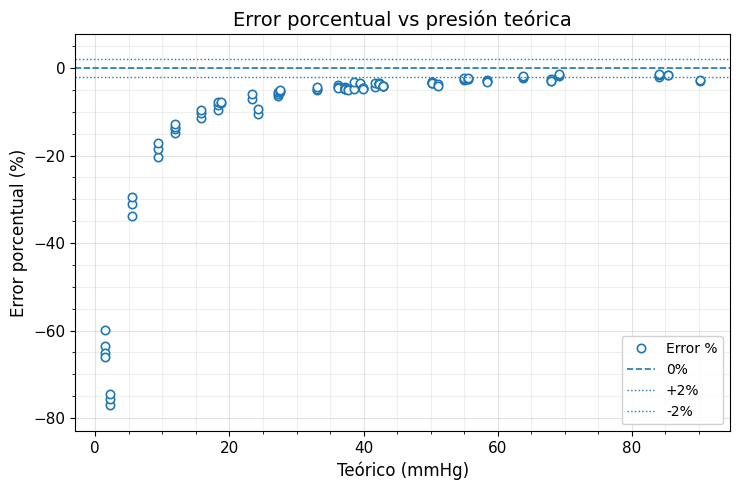

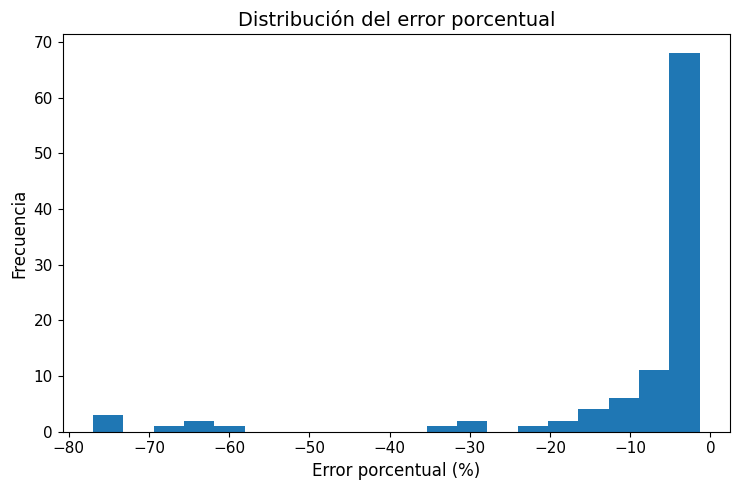

In [46]:
# ---------- Error porcentual ----------
# Evitar división por ~0: enmascaramos x muy pequeños
eps = 1e-9
mask_x = np.abs(x) > eps

Eperc = np.full_like(y, np.nan, dtype=float)
Eperc[mask_x] = 100.0 * (y[mask_x] - x[mask_x]) / x[mask_x]

# Guardar CSV con error porcentual
pd.DataFrame({
    "mmHg_theory": x,
    "mmHg_exp": y,
    "percent_error": Eperc
}).to_csv("percent_error.csv", index=False)

# Métricas resumidas de error porcentual
valid = np.isfinite(Eperc)
mape = float(np.mean(np.abs(Eperc[valid]))) if np.any(valid) else np.nan
medAPE = float(np.median(np.abs(Eperc[valid]))) if np.any(valid) else np.nan
meanPE = float(np.mean(Eperc[valid])) if np.any(valid) else np.nan
stdPE  = float(np.std(Eperc[valid], ddof=1)) if np.any(valid) else np.nan

print(f"Error porcentual: MAPE={mape:.3f}% | Mediana abs={medAPE:.3f}% | Media={meanPE:.3f}% | SD={stdPE:.3f}%")

# Añadir estas métricas al resumen
summary_extra = pd.DataFrame({
    "metric": ["MAPE_percent", "Median_abs_percent_error", "Mean_percent_error", "SD_percent_error"],
    "value":  [mape,           medAPE,                    meanPE,               stdPE]
})
summary_all = pd.concat([summary, summary_extra], ignore_index=True)
summary_all.to_csv("fit_summary.csv", index=False)

# ---------- Gráfico: Error porcentual vs presión teórica ----------
fig, ax = plt.subplots()
ax.plot(x[valid], Eperc[valid], 'o', markersize=6, markerfacecolor='white', markeredgewidth=1.2, label="Error %")
ax.axhline(0, linestyle='--', linewidth=1.2, label="0%")
# Bandas de referencia opcionales (comenta o ajusta si no las quieres):
ax.axhline(2, linestyle=':', linewidth=1.0, label="+2%")
ax.axhline(-2, linestyle=':', linewidth=1.0, label="-2%")

# Reutiliza tu helper si ya está definido
try:
    _beautify(ax, "Teórico (mmHg)", "Error porcentual (%)", "Error porcentual vs presión teórica", x[valid], Eperc[valid])
except NameError:
    ax.set_xlabel("Teórico (mmHg)")
    ax.set_ylabel("Error porcentual (%)")
    ax.set_title("Error porcentual vs presión teórica")
    ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig("percent_error_vs_theory.png", dpi=300)
plt.show()

# ---------- (Opcional) Histograma de error porcentual ----------
fig, ax = plt.subplots()
ax.hist(Eperc[valid], bins=20)
ax.set_xlabel("Error porcentual (%)")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución del error porcentual")
plt.tight_layout()
plt.savefig("percent_error_hist.png", dpi=300)
plt.show()
